# __<ins>Projet Prédiction Conforme<ins>__

1. __Objectif__

Ce notebook a pour objectif d'implémenter et d'évaluer différentes méthodes de Prédiction Conforme (Conformal Prediction - CP). L'objectif n'est pas seulement de générer des prédictions, mais de quantifier l'incertitude de ces prédictions en produisant des intervalles de prédiction (pour la régression) et des ensembles de prédiction (pour la classification) qui sont statistiquement valides (c'est-à-dire qu'ils garantissent la couverture).

2. __Tâches et Datasets__

Deux tâches distinctes sont utilisées pour illustrer les méthodes de CP :

- <ins>Tâche 1 :<ins> Régression

    + Objectif : Prédire les coûts médicaux annuels (annual_medical_cost).

    + Dataset : Medical Insurance Cost Prediction (Kaggle)

- <ins>Tâche 2 :<ins> Classification

    + Objectif : Classifier l'état de santé fœtale (normal, suspect, pathologique).

    + Dataset : Cardiotocography (UCI)

3. __Plan d'Exécution__

Le notebook est divisé en trois parties principales :

- <ins>Modélisation de base (Régression Quantile) :<ins>

    + Préparation des données de régression.

    + Entraînement de modèles de Régression Quantile (QR) pour estimer la distribution conditionnelle des coûts. Cette étape sert de fondation aux méthodes CP avancées.

- <ins>Prédiction Conforme pour la Régression :<ins>

    + Application de méthodes de CP (notamment CQR - Conformalized Quantile Regression) pour calibrer les intervalles de QR et garantir une couverture de prédiction (ex: 90%).

- <ins>Prédiction Conforme pour la Classification :<ins>

    + Application de méthodes de CP (telles que APS - Adaptive Prediction Sets) sur le dataset de classification pour générer des ensembles de classes valides.

## <ins>__Régression Quantile__<ins>

L'objectif de cette partie est de modéliser la variable cible annual_medical_cost du dataset d'assurance. Cependant, les données de coûts (financiers, médicaux) sont rarement adaptées à une régression linéaire standard (prédisant la moyenne). Elle présente comme caractériqtique une hétéroscédasticité, c'est-à-dire que la variance des coûts n'est pas constante. Par exemple, les coûts médicaux des individus à haut risque (risk_score élevé) sont non seulement plus élevés, mais aussi plus variables (moins prévisibles) que ceux des individus à faible risque. Pour capturer cette complexité, nous utilisons la Régression Quantile (QR).

### __Exploratory Data Analysis__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

/home/clement/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('medical_insurance/medical_insurance.csv')
df.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [3]:
display(df.describe())
df.info()

,person_id,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,50000.500000,47.521500,4.987390e+04,2.430900,0.898380,26.990512,1.92765,0.093640,0.373350,1.236320,...,0.014770,0.108310,0.130140,0.508530,0.158690,0.508390,0.50933,0.509140,0.367810,0.169700
std,28867.657797,15.988752,4.680021e+04,1.075126,0.950654,4.994883,1.73773,0.304848,1.373011,1.209358,...,0.120632,0.310773,0.336459,0.749755,0.463562,0.747218,0.75363,0.750455,0.482212,0.375371
min,1.000000,0.000000,1.100000e+03,1.000000,0.000000,12.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25000.750000,37.000000,2.110000e+04,2.000000,0.000000,23.600000,1.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,50000.500000,48.000000,3.620000e+04,2.000000,1.000000,27.000000,2.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,75000.250000,58.000000,6.220000e+04,3.000000,1.000000,30.400000,3.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000
max,100000.000000,100.000000,1.061800e+06,9.000000,7.000000,50.400000,25.00000,3.000000,21.000000,11.000000,...,1.000000,1.000000,1.000000,7.000000,6.000000,7.000000,7.00000,7.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [4]:
df.isnull().sum()

person_id                          0
age                                0
sex                                0
region                             0
urban_rural                        0
income                             0
education                          0
marital_status                     0
employment_status                  0
household_size                     0
dependents                         0
bmi                                0
smoker                             0
alcohol_freq                   30083
visits_last_year                   0
hospitalizations_last_3yrs         0
days_hospitalized_last_3yrs        0
medication_count                   0
systolic_bp                        0
diastolic_bp                       0
ldl                                0
hba1c                              0
plan_type                          0
network_tier                       0
deductible                         0
copay                              0
policy_term_years                  0
p

Categorical features value counts:
sex: Counter({'Female': 49193, 'Male': 48794, 'Other': 2013})
region: Counter({'South': 28029, 'North': 22027, 'East': 19984, 'West': 17879, 'Central': 12081})
urban_rural: Counter({'Urban': 60019, 'Suburban': 25021, 'Rural': 14960})
education: Counter({'Bachelors': 27996, 'Some College': 25112, 'HS': 24827, 'Masters': 13987, 'No HS': 5120, 'Doctorate': 2958})
marital_status: Counter({'Married': 53252, 'Single': 35715, 'Divorced': 6984, 'Widowed': 4049})
employment_status: Counter({'Employed': 55269, 'Retired': 19864, 'Unemployed': 12939, 'Self-employed': 11928})
alcohol_freq: Counter({'Occasional': 45078, nan: 30083, 'Weekly': 19833, 'Daily': 5006})
smoker: Counter({'Never': 69709, 'Former': 18163, 'Current': 12128})
plan_type: Counter({'PPO': 35167, 'HMO': 34723, 'EPO': 15121, 'POS': 14989})
network_tier: Counter({'Silver': 40177, 'Bronze': 29932, 'Gold': 19882, 'Platinum': 10009})


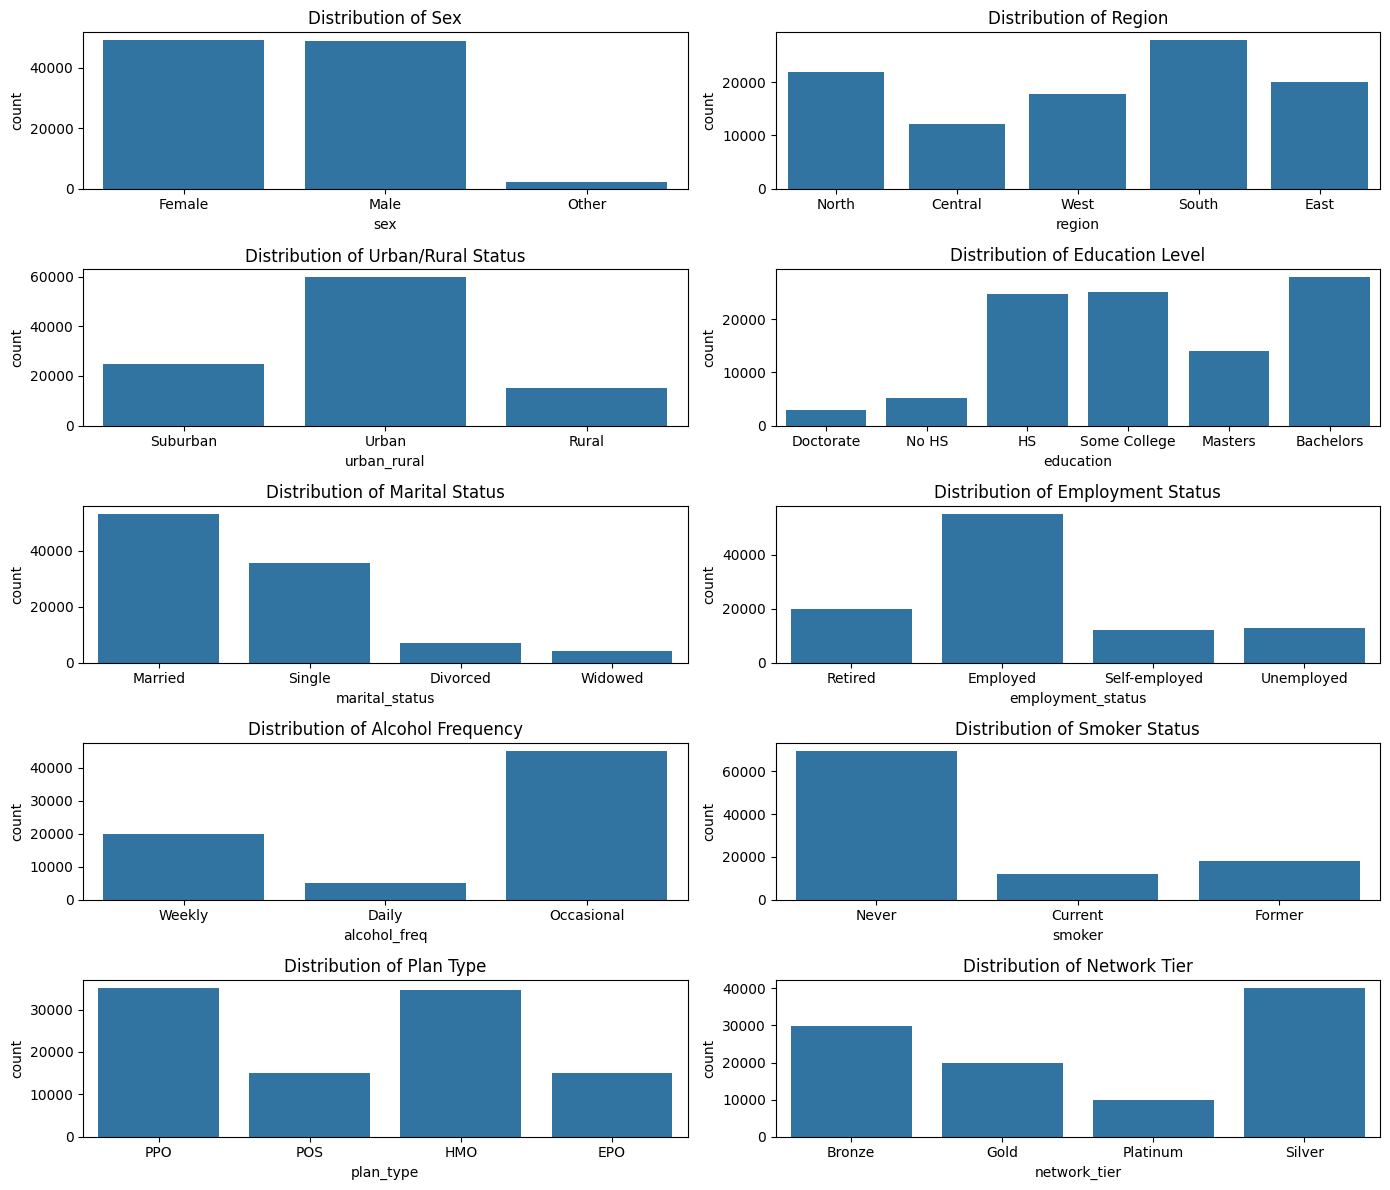

In [33]:
from collections import Counter

categorical_features = ['sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'alcohol_freq', 'smoker', 
                        'plan_type', 'network_tier']

print("Categorical features value counts:")
for feature in categorical_features:
    print(f"{feature}: {Counter(df[feature])}")

plt.figure(figsize=(14, 12))
plt.subplot(5, 2, 1)
sns.countplot(data=df, x='sex')
plt.title('Distribution of Sex')
plt.subplot(5, 2, 2)
sns.countplot(data=df, x='region')
plt.title('Distribution of Region')
plt.subplot(5, 2, 3)
sns.countplot(data=df, x='urban_rural')
plt.title('Distribution of Urban/Rural Status')
plt.subplot(5, 2, 4)
sns.countplot(data=df, x='education')
plt.title('Distribution of Education Level')
plt.subplot(5, 2, 5)
sns.countplot(data=df, x='marital_status')
plt.title('Distribution of Marital Status')
plt.subplot(5, 2, 6)
sns.countplot(data=df, x='employment_status')
plt.title('Distribution of Employment Status')
plt.subplot(5, 2, 7)
sns.countplot(data=df, x='alcohol_freq')
plt.title('Distribution of Alcohol Frequency')
plt.subplot(5, 2, 8)
sns.countplot(data=df, x='smoker')
plt.title('Distribution of Smoker Status')
plt.subplot(5, 2, 9)
sns.countplot(data=df, x='plan_type')
plt.title('Distribution of Plan Type')
plt.subplot(5, 2, 10)
sns.countplot(data=df, x='network_tier')
plt.title('Distribution of Network Tier')

plt.tight_layout()
plt.show()



MATRICE DE CORRÉLATION DES FEATURES NUMÉRIQUES


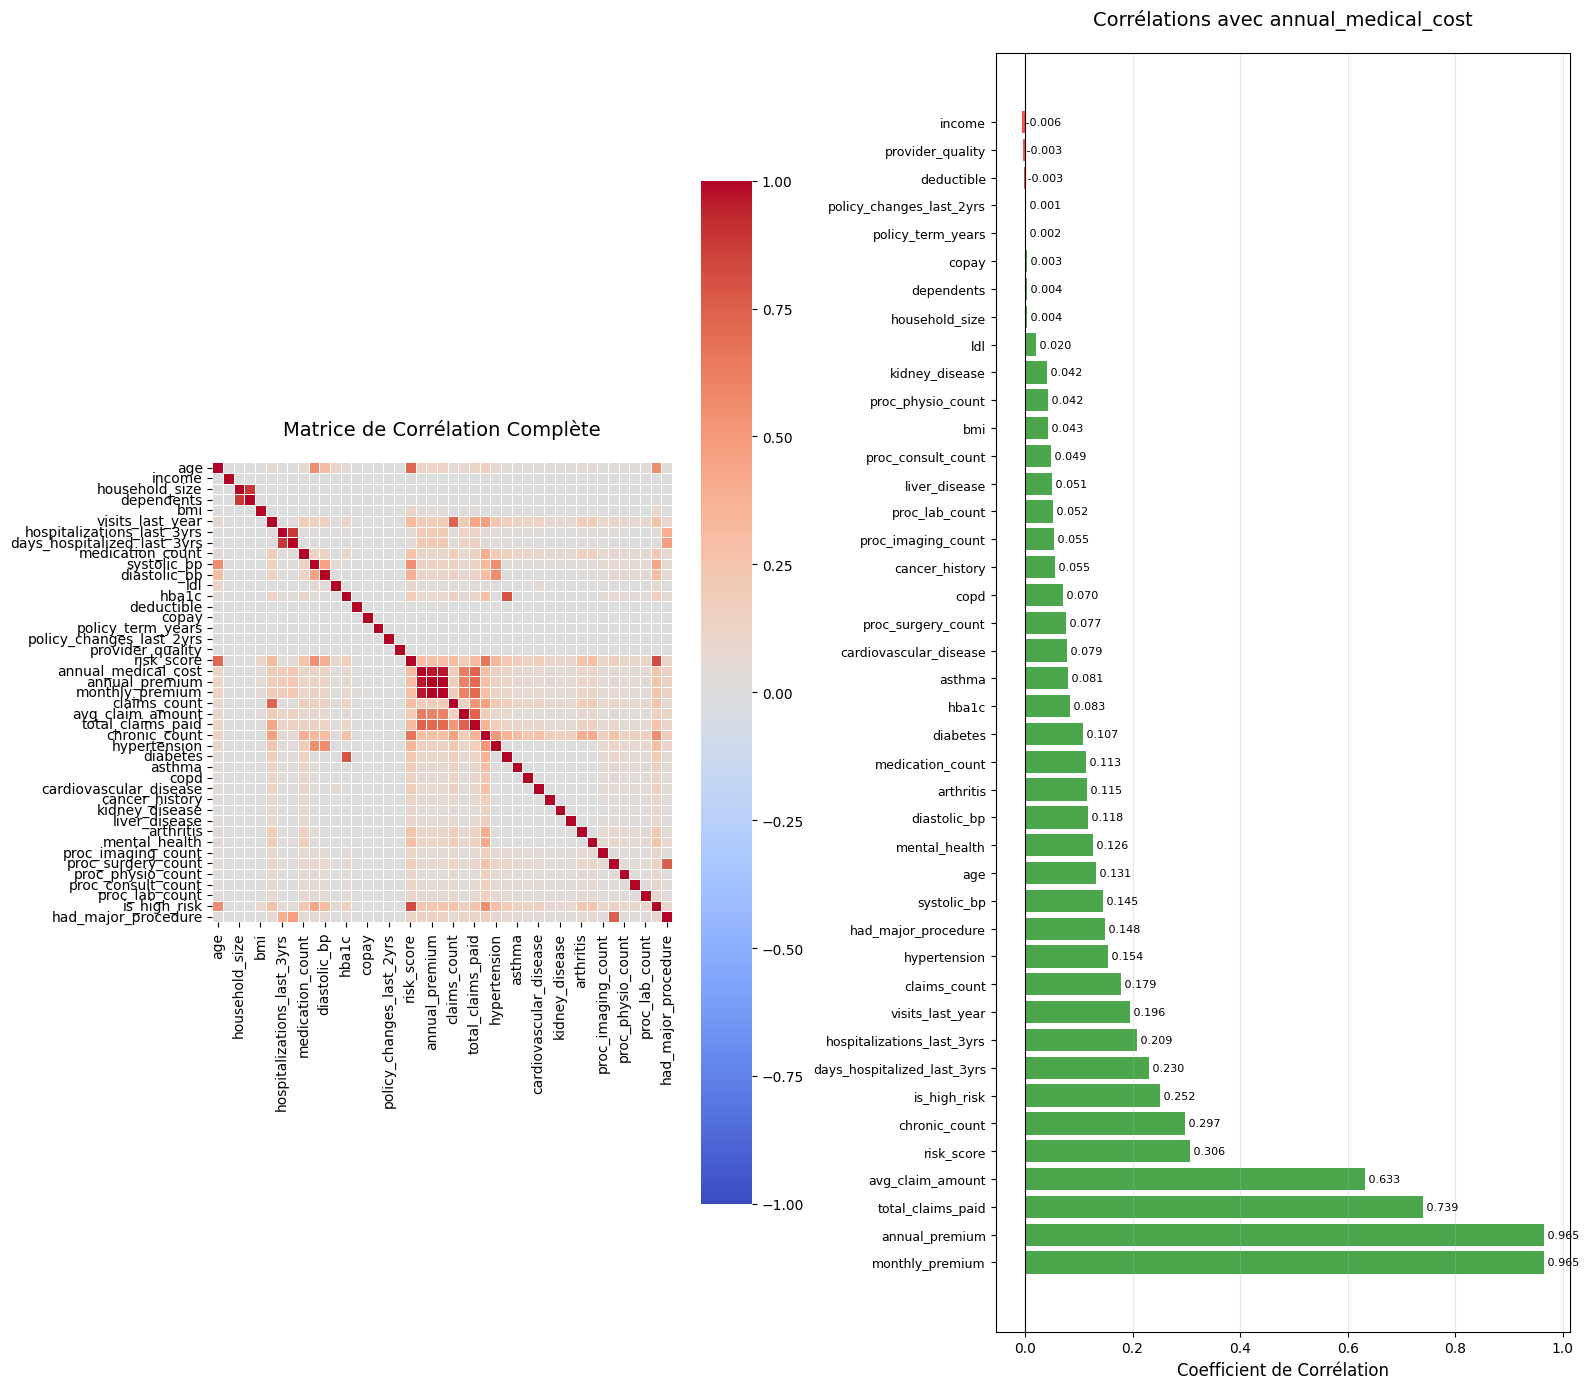


Top 10 corrélations positives avec annual_medical_cost:
monthly_premium                0.965416
annual_premium                 0.965415
total_claims_paid              0.739402
avg_claim_amount               0.632996
risk_score                     0.305971
chronic_count                  0.296720
is_high_risk                   0.251923
days_hospitalized_last_3yrs    0.230246
hospitalizations_last_3yrs     0.208640
visits_last_year               0.195631
Name: annual_medical_cost, dtype: float64

Top 10 corrélations négatives avec annual_medical_cost:
kidney_disease              0.041799
ldl                         0.020406
household_size              0.004431
dependents                  0.003866
copay                       0.002961
policy_term_years           0.002207
policy_changes_last_2yrs    0.001032
deductible                 -0.002538
provider_quality           -0.003214
income                     -0.005974
Name: annual_medical_cost, dtype: float64


In [ ]:
def plot_correlation_matrix(df, figsize=(16, 14)):
    """
    Visualise la matrice de corrélation des features numériques
    """
    print("\n" + "="*70)
    print("MATRICE DE CORRÉLATION DES FEATURES NUMÉRIQUES")
    print("="*70)
    
    # Sélectionner uniquement les features numériques
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    # Exclure person_id
    numeric_cols = [col for col in numeric_cols if col != 'person_id']
    
    # Calculer la matrice de corrélation
    corr_matrix = df[numeric_cols].corr()
    
    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Matrice complète avec annotations
    sns.heatmap(corr_matrix, 
                annot=False,  
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8},
                ax=axes[0],
                vmin=-1, vmax=1)
    axes[0].set_title('Matrice de Corrélation Complète', fontsize=14, pad=20)
    
    # Plot 2: Top corrélations avec annual_medical_cost
    if 'annual_medical_cost' in corr_matrix.columns:
        target_corr = corr_matrix['annual_medical_cost'].drop('annual_medical_cost').sort_values(ascending=False)
        
        colors = ['green' if x > 0 else 'red' for x in target_corr.values]
        axes[1].barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
        axes[1].set_yticks(range(len(target_corr)))
        axes[1].set_yticklabels(target_corr.index, fontsize=9)
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[1].set_xlabel('Coefficient de Corrélation', fontsize=12)
        axes[1].set_title('Corrélations avec annual_medical_cost', fontsize=14, pad=20)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Afficher les valeurs
        for i, v in enumerate(target_corr.values):
            axes[1].text(v, i, f' {v:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les top corrélations dans la console
    if 'annual_medical_cost' in corr_matrix.columns:
        print("\nTop 10 corrélations positives avec annual_medical_cost:")
        print(target_corr.head(10))
        print("\nTop 10 corrélations négatives avec annual_medical_cost:")
        print(target_corr.tail(10))
    
    return corr_matrix

corr_matrix = plot_correlation_matrix(df)

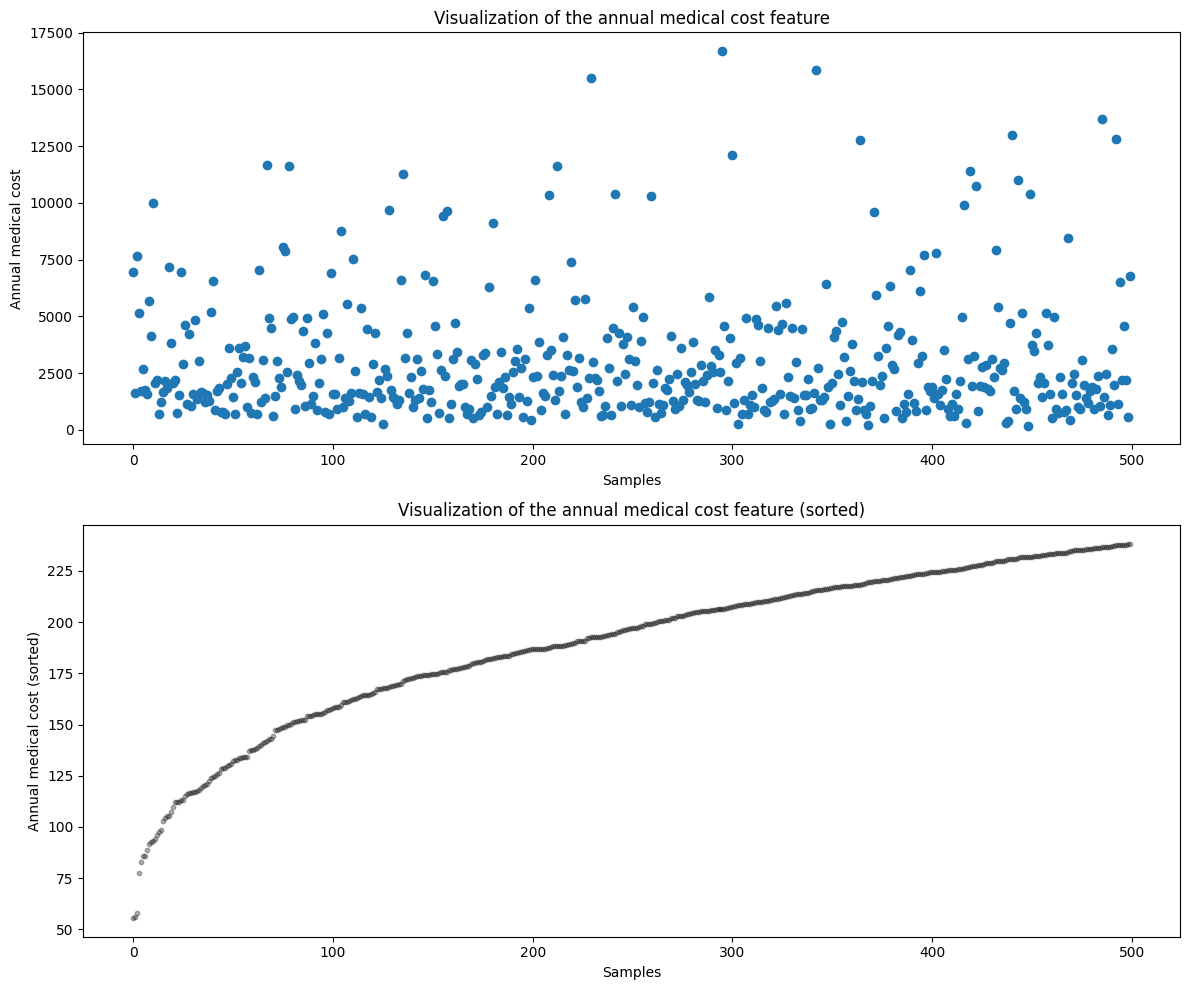

In [7]:
sorted_idx = np.argsort(df['annual_medical_cost'].values)[:500]
y_sorted = df['annual_medical_cost'].iloc[sorted_idx].values
x_plot = np.arange(len(sorted_idx))

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.scatter(x_plot, df['annual_medical_cost'][:500])
plt.xlabel('Samples')
plt.ylabel('Annual medical cost')
plt.title('Visualization of the annual medical cost feature')

plt.subplot(2, 1, 2)
plt.scatter(x_plot, y_sorted, alpha=0.3, s=10, c='black', label='Real')
plt.xlabel('Samples')
plt.ylabel('Annual medical cost (sorted)')
plt.title('Visualization of the annual medical cost feature (sorted)')

plt.tight_layout()
plt.show()


### __Preprocessing__

Le preprocessing des données est effectué en trois étapes critiques pour assurer la validité du modèle et préparer les données pour l'entraînement.

1. Gestion des données manquantes La feature alcohol_freq est supprimée. Elle présente plus de 30% de valeurs manquantes. Tenter une imputation sur un volume aussi important risquerait d'introduire un biais significatif dans le modèle.

2. Élimination de la Fuite de Données (Data Leakage) Les features monthly_premium, annual_premium, total_claims_paid et avg_claim_amount sont impérativement supprimées. Ces variables ne sont pas des prédicteurs, mais des conséquences ou des proxys directs de la variable cible annual_medical_cost. Leur inclusion fausserait l'évaluation du modèle et le rendrait inutilisable en production.

3. Transformation des Features Les features restantes sont traitées à l'aide d'un ColumnTransformer :

    - Features Numériques : Elles sont standardisées (mises à l'échelle) à l'aide de StandardScaler pour centrer les données et réduire l'impact des différentes échelles.
    - Features Catégorielles : Elles sont converties en représentation numérique via OneHotEncoder (encodage One-Hot).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def prepare_data_quantile_regression(df, target_col='annual_medical_cost'):
    """
    Prépare la donnée
    - Supprime les features inutiles/leaks
    - Applique le preprocessing (Scaling, OHE)
    """
    # Colonnes à supprimer
    features_leakage = ['monthly_premium', 'annual_premium', 'total_claims_paid', 'avg_claim_amount']
    feature_missing = ['alcohol_freq']
    identifier = ['person_id'] 
    
    # Séparer X et y
    try:
        y = df[target_col]
        X = df.drop(columns=features_leakage + feature_missing + identifier + [target_col])
    except KeyError as e:
        print(f"Erreur de colonne : {e}. Vérifiez le DataFrame.")
        # Filtrer les colonnes qui existent réellement pour la suppression
        cols_to_drop = [col for col in features_leakage + feature_missing + identifier + [target_col] if col in df.columns]
        y = df[target_col]
        X = df.drop(columns=cols_to_drop)

    # Identifier les types de features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    # Définir le préprocesseur
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 
             categorical_features)
        ],
        remainder='passthrough' 
    )
    
    # Split train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Appliquer le préprocesseur
    preprocessor.fit(X_train)
    
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Récupérer les noms des features après OHE
    feature_names = numeric_features + \
                    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    
    # Convertir en DataFrames
    X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
    X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)
    
    print(f"Features numériques: {len(numeric_features)}")
    print(f"Features catégorielles: {len(categorical_features)}")
    print(f"Shape X_train traité: {X_train_processed.shape}")
    print(f"Shape X_test traité: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data_quantile_regression(df)
X_train

Features numériques: 38
Features catégorielles: 9
Shape X_train traité: (80000, 65)
Shape X_test traité: (20000, 65)


,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,employment_status_Self-employed,employment_status_Unemployed,smoker_Former,smoker_Never,plan_type_HMO,plan_type_POS,plan_type_PPO,network_tier_Gold,network_tier_Platinum,network_tier_Silver
75220,1.590727,0.380791,-0.400559,-0.944574,0.462958,-0.533441,-0.306627,-0.271591,-1.021969,1.118491,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48955,-0.285208,0.861909,-0.400559,-0.944574,-0.579859,-0.533441,-0.306627,-0.271591,-1.021969,0.141730,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
44966,1.403134,0.305950,-0.400559,-0.944574,1.987075,0.043213,-0.306627,-0.271591,0.629648,-0.118739,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
13568,-0.973051,-0.510882,-0.400559,-0.944574,1.706317,-0.533441,-0.306627,-0.271591,-1.021969,-0.248974,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
92727,-0.910519,-0.380445,0.530974,0.108301,1.104692,-1.110095,-0.306627,-0.271591,-0.196160,-0.314091,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.215042,0.137024,-0.400559,0.108301,1.525829,0.043213,-0.306627,-0.271591,-1.021969,1.378961,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
54886,-1.535831,0.316642,1.462507,1.161177,-1.983650,-0.533441,-0.306627,-0.271591,-1.021969,1.444078,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
76820,0.777822,-0.551510,-0.400559,0.108301,0.182200,-1.110095,-0.306627,-0.271591,-0.196160,0.467317,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
860,0.840353,-0.669117,-0.400559,0.108301,0.162146,0.619867,-0.306627,-0.271591,0.629648,-0.118739,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### __Entrainement et visualisation__

L'analyse est scindée en deux étapes pour différencier l'explication visuelle de la performance prédictive.

1. Modèle 1D (Pédagogique) : risk_score

    - Une première régression quantile est réalisée en utilisant uniquement la feature risk_score.
    - risk_score est choisie car elle présente la corrélation la plus élevée (0.360) avec annual_medical_cost (parmi les features valides, après suppression des fuites de données).
    - L'objectif de ce modèle simple n'est pas la performance, mais la visualisation. Il permet de générer un graphique 2D pour illustrer concrètement comment les lignes de quantiles capturent la distribution et l'hétéroscédasticité des coûts.

2. Modèle Complet (Performance)

    - Une seconde régression quantile est ensuite entraînée sur l'ensemble du dataset prétraité (toutes les features).
    - Ce modèle multidimensionnel vise la performance prédictive. Il sera évalué quantitativement (Pinball Loss, couverture) et servira de base à la prédiction conforme.

In [29]:
from sklearn.metrics import mean_pinball_loss, mean_absolute_error

def evaluate_quantile_models(models, X_test, y_test, quantiles):
    """
    Évalue les modèles en utilisant les métriques sklearn.
    """
    results = []
    
    for q in quantiles:
        y_pred = models[q].predict(X_test)
        
        # Utilisation de sklearn.metrics
        pinball = mean_pinball_loss(y_test, y_pred, alpha=q)
        mae = mean_absolute_error(y_test, y_pred)
        
        results.append({
            'quantile': q,
            'pinball_loss': pinball,
            'mae': mae,
            'mean_prediction': y_pred.mean(),
            'std_prediction': y_pred.std()
        })
    
    return pd.DataFrame(results)

def calculate_coverage(models, X_test, y_test, lower_q=0.05, upper_q=0.95):
    """
    Calcule la couverture de l'intervalle de prédiction.
    """
    y_lower = models[lower_q].predict(X_test)
    y_upper = models[upper_q].predict(X_test)
    
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    
    print(f"\nCouverture [{lower_q}-{upper_q}]: {coverage:.2%}")
    print(f"Couverture théorique: {upper_q - lower_q:.2%}")
    
    return coverage

Entraînement des modèles 1D...


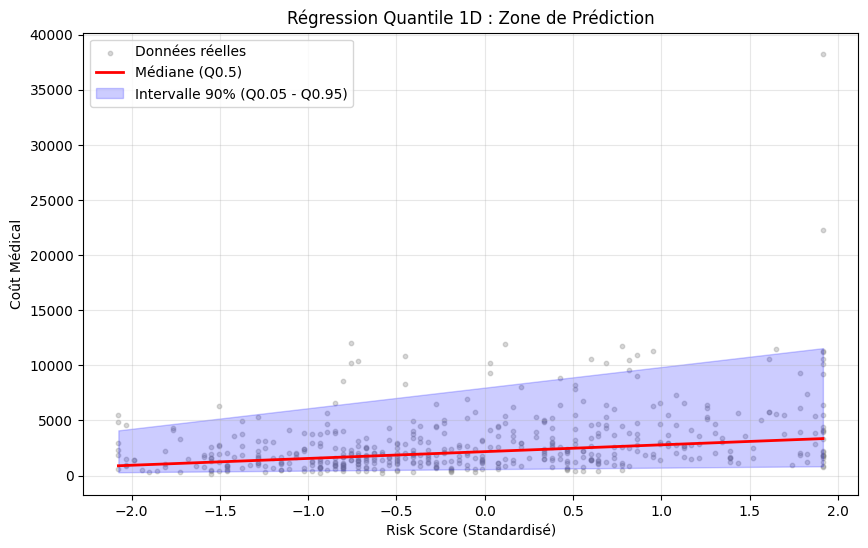

In [ ]:
from sklearn.linear_model import QuantileRegressor

# Préparation 1D 
feature_1d = 'risk_score'
target = 'annual_medical_cost'

X_1d = df[[feature_1d]] 
y = df[target]

X_train_1d, X_test_1d, y_train, y_test_1d = train_test_split(X_1d, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_1d_scaled = scaler.fit_transform(X_train_1d)
X_test_1d_scaled = scaler.transform(X_test_1d)

# Entraînement
quantiles = [0.05, 0.5, 0.95]
models_1d = {}

print("Entraînement des modèles 1D...")
for q in quantiles:
    reg = QuantileRegressor(quantile=q, alpha=0.01, solver='highs')
    reg.fit(X_train_1d_scaled, y_train)
    models_1d[q] = reg

# Visualisation avec Zone Colorée
plt.figure(figsize=(10, 6))

x_grid = np.linspace(X_test_1d_scaled.min(), X_test_1d_scaled.max(), 200).reshape(-1, 1)

y_pred_low = models_1d[0.05].predict(x_grid)
y_pred_med = models_1d[0.5].predict(x_grid)
y_pred_high = models_1d[0.95].predict(x_grid)

plt.scatter(X_test_1d_scaled[:500], y_test.iloc[:500], color='gray', alpha=0.3, s=10, label='Données réelles')

plt.plot(x_grid, y_pred_med, color='red', linewidth=2, label='Médiane (Q0.5)')

plt.fill_between(
    x_grid.ravel(), 
    y_pred_low, 
    y_pred_high, 
    color='blue', 
    alpha=0.2, 
    label='Intervalle 90% (Q0.05 - Q0.95)'
)

plt.xlabel('Risk Score (Standardisé)')
plt.ylabel('Coût Médical')
plt.title('Régression Quantile 1D : Zone de Prédiction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [32]:
results = evaluate_quantile_models(models_1d, X_test_1d, y_test_1d, quantiles=[0.05, 0.5, 0.95])
coverage = calculate_coverage(models_1d, X_test_1d, y_test_1d, lower_q=0.05, upper_q=0.95)

results


Couverture [0.05-0.95]: 87.62%
Couverture théorique: 90.00%


/home/clement/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/clement/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/clement/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/clement/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/clement/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(


,quantile,pinball_loss,mae,mean_prediction,std_prediction
0,0.05,132.833315,2403.062158,652.907239,34.109121
1,0.50,915.181008,1830.362015,2492.777406,154.905148
2,0.95,483.759004,6299.656533,8952.389519,469.089455


In [ ]:
from sklearn.linear_model import QuantileRegressor

def train_linear_quantile(X_train_processed, y_train, quantiles=[0.05, 0.5, 0.95]):
    """
    Entraîne le QuantileRegressor.

    Args:
        X_train_processed (pd.DataFrame): Données d'entraînement prétraitées.
        y_train (pd.Series): Cible d'entraînement.
        quantiles (list): Liste des quantiles à entraîner.

    Returns:
        dict: Un dictionnaire de modèles entraînés {quantile: model}.
    """
    models = {}
    
    for q in quantiles:
        print(f"Entraînement pour le quantile {q}...")
        
        regressor = QuantileRegressor(
            quantile=q,
            alpha=0.01,  
            solver='highs' 
        )
        
        # Entraînement direct sur les données traitées
        regressor.fit(X_train_processed, y_train)
        models[q] = regressor
        
    return models

quantile_models = train_linear_quantile(X_train, y_train, quantiles=[0.05, 0.5, 0.95])
quantile_models

Entraînement pour le quantile 0.05...
Entraînement pour le quantile 0.5...
Entraînement pour le quantile 0.95...


{0.05: QuantileRegressor(alpha=0.01, quantile=0.05),
 0.5: QuantileRegressor(alpha=0.01),
 0.95: QuantileRegressor(alpha=0.01, quantile=0.95)}

In [30]:
results = evaluate_quantile_models(quantile_models, X_test, y_test, quantiles=[0.05, 0.5, 0.95])
coverage = calculate_coverage(quantile_models, X_test, y_test, lower_q=0.05, upper_q=0.95)

results


Couverture [0.05-0.95]: 89.89%
Couverture théorique: 90.00%


,quantile,pinball_loss,mae,mean_prediction,std_prediction
0,0.05,127.979258,2437.364369,604.006876,162.397317
1,0.50,833.565760,1667.131521,2229.628333,831.044005
2,0.95,420.134896,5034.140479,7687.647476,2324.052736


/tmp/ipykernel_284696/307642575.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_data, labels=[f'Q{q}' for q in quantiles])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


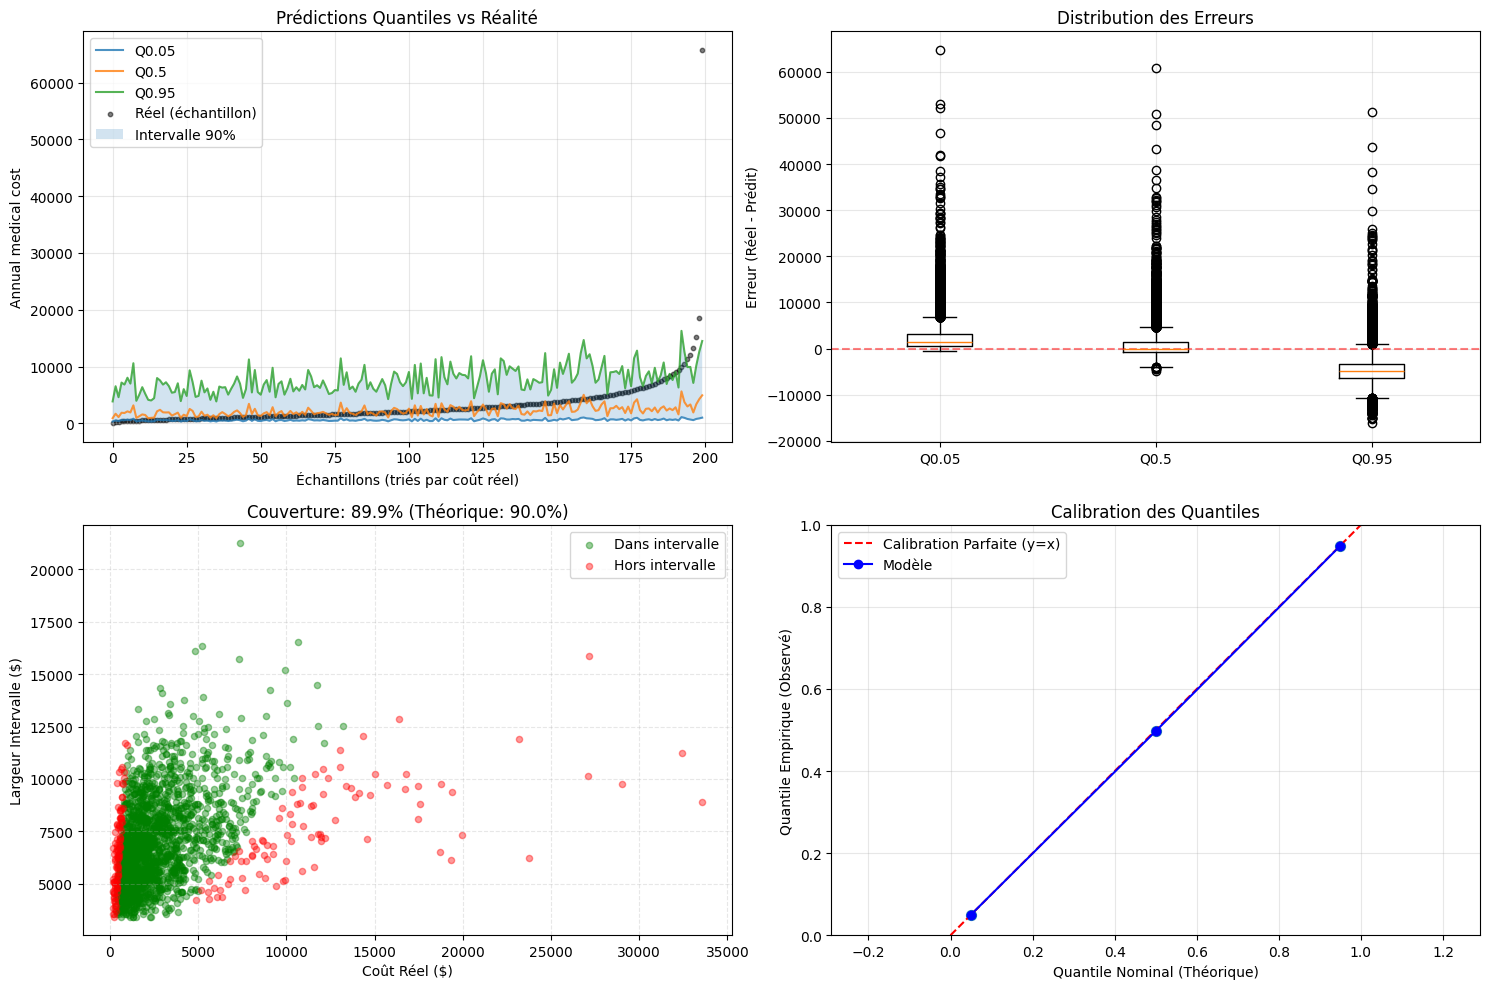

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_quantile_predictions_v2(models, X_test, y_test, quantiles, n_samples=200):
    """
    Visualise les prédictions quantiles vs les valeurs réelles.
    Mise à jour avec le Plot 4 (Calibration).
    """
    
    # Assurer que les quantiles sont triés pour les plots
    quantiles = sorted(quantiles)

    # Échantillonnage pour Plot 1
    sorted_idx_full = np.argsort(y_test.values)
    plot_indices = sorted_idx_full[np.linspace(0, len(sorted_idx_full) - 1, n_samples).astype(int)]
    y_sorted_sample = y_test.iloc[plot_indices].values
    X_test_sample = X_test.iloc[plot_indices]
    x_plot = np.arange(n_samples) 

    plt.figure(figsize=(15, 10))
    
    # --- Plot 1: Intervalles de prédiction ---
    plt.subplot(2, 2, 1)
    predictions = {}
    for q in quantiles:
        y_pred = models[q].predict(X_test_sample) 
        predictions[q] = y_pred
        plt.plot(x_plot, y_pred, label=f'Q{q}', alpha=0.8)
    
    plt.scatter(x_plot, y_sorted_sample, alpha=0.5, s=10, c='black', label='Réel (échantillon)')
    
    q_lower = quantiles[0]
    q_upper = quantiles[-1]
    plt.fill_between(x_plot, predictions[q_lower], predictions[q_upper], 
                     alpha=0.2, label=f'Intervalle {q_upper-q_lower:.0%}')
    
    plt.xlabel('Échantillons (triés par coût réel)')
    plt.ylabel('Annual medical cost')
    plt.title('Prédictions Quantiles vs Réalité')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # --- Plot 2: Distribution des erreurs ---
    plt.subplot(2, 2, 2)
    errors_data = []
    for q in quantiles:
        y_pred = models[q].predict(X_test)
        errors = y_test - y_pred
        errors_data.append(errors)
    
    plt.boxplot(errors_data, labels=[f'Q{q}' for q in quantiles])
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.ylabel('Erreur (Réel - Prédit)')
    plt.title('Distribution des Erreurs')
    plt.grid(alpha=0.3)

    # --- Plot 3: Largeur de l'intervalle vs Coût réel ---
    plt.subplot(2, 2, 3)
    q_lower = quantiles[0]
    q_upper = quantiles[-1]
    
    y_lower_all_np = models[q_lower].predict(X_test)
    y_upper_all_np = models[q_upper].predict(X_test)
    
    y_lower_all = pd.Series(y_lower_all_np, index=y_test.index)
    y_upper_all = pd.Series(y_upper_all_np, index=y_test.index)
    
    in_interval = (y_test >= y_lower_all) & (y_test <= y_upper_all)
    out_interval = ~in_interval
    interval_width = y_upper_all - y_lower_all
    
    sample_idx_plot3 = np.random.choice(X_test.index, 2000, replace=False)
    
    plt.scatter(y_test.loc[sample_idx_plot3][in_interval.loc[sample_idx_plot3]], 
                interval_width.loc[sample_idx_plot3][in_interval.loc[sample_idx_plot3]], 
                alpha=0.4, s=20, label='Dans intervalle', color='green')
    plt.scatter(y_test.loc[sample_idx_plot3][out_interval.loc[sample_idx_plot3]], 
                interval_width.loc[sample_idx_plot3][out_interval.loc[sample_idx_plot3]], 
                alpha=0.4, s=20, label='Hors intervalle', color='red')
    
    coverage_pct = in_interval.mean()
    theorical_pct = q_upper - q_lower
    
    plt.xlabel('Coût Réel ($)')
    plt.ylabel('Largeur Intervalle ($)')
    plt.title(f'Couverture: {coverage_pct:.1%} (Théorique: {theorical_pct:.1%})')
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')
    
    # --- Plot 4: Calibration des Quantiles ---
    plt.subplot(2, 2, 4)
    
    empirical_quantiles = []
    
    for q in quantiles:
        y_pred = models[q].predict(X_test)
        empirical_q = np.mean(y_test <= y_pred)
        empirical_quantiles.append(empirical_q)
        
    # Ligne parfaite (y=x)
    plt.plot([0, 1], [0, 1], 'r--', label='Calibration Parfaite (y=x)')
    
    # Plot des points de calibration
    plt.plot(quantiles, empirical_quantiles, 'bo-', label='Modèle')
    plt.scatter(quantiles, empirical_quantiles, s=50)

    plt.xlabel('Quantile Nominal (Théorique)')
    plt.ylabel('Quantile Empirique (Observé)')
    plt.title('Calibration des Quantiles')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

quantiles_list = [0.05, 0.5, 0.95]
plot_quantile_predictions_v2(quantile_models, X_test, y_test, quantiles=quantiles_list)

### __Analyse__

Le modèle 1D a servi à visualiser le concept d'hétéroscédasticité, mais ses intervalles ne sont pas fiables (sous-couverture).

Le modèle complet est non seulement plus précis (MAE plus faible), mais il produit également des intervalles de prédiction (Q0.05-Q0.95) qui sont déjà très fiables "sortis de la boîte".

Cette excellente calibration de base est idéale pour la Prédiction Conforme (CQR), dont le rôle sera de corriger le léger écart résiduel (de 89.89% à 90.00%) pour garantir formellement la couverture sur les nouvelles données.

## <ins>__Prédiction Conforme pour la régression__<ins>

L'objectif de cette partie est de quantifier l'incertitude de nos prédictions en générant des intervalles de coûts (ex: [2500\$, 4500\$]) qui garantissent une couverture de 90%.

Nous implémentons et comparons deux méthodes de "split-conformal". D'abord, la SCP standard, qui utilise une LinearRegression et produit des intervalles de largeur constante, inadaptés à nos données. Ensuite, la CQR (Conformalized Quantile Regression), qui s'appuie sur nos modèles quantiles pour créer des intervalles de largeur adaptative, bien plus pertinents pour ce problème.

### __Preprocessing__

In [ ]:
def prepare_data_conformal(df, target_col='annual_medical_cost', cal_size=0.2, test_size=0.2, random_state=42):
    """
    Prépare la donnée pour la prédiction conforme (Train / Calibration / Test)
    """
    
    # Colonnes à supprimer
    features_leakage = ['monthly_premium', 'annual_premium', 'total_claims_paid', 'avg_claim_amount']
    feature_missing = ['alcohol_freq']
    identifier = ['person_id']
    
    try:
        y = df[target_col]
        X = df.drop(columns=features_leakage + feature_missing + identifier + [target_col])
    except KeyError:
        cols_to_drop = [col for col in features_leakage + feature_missing + identifier + [target_col] if col in df.columns]
        y = df[target_col]
        X = df.drop(columns=cols_to_drop)

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 
             categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Split en 3 ensembles
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    cal_size_adjusted = cal_size / (1.0 - test_size)
    
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_temp, y_temp, test_size=cal_size_adjusted, random_state=random_state
    )
    
    # Application du préprocesseur
    preprocessor.fit(X_train)
    
    X_train_processed = preprocessor.transform(X_train)
    X_cal_processed = preprocessor.transform(X_cal)
    X_test_processed = preprocessor.transform(X_test)
    
    try:
        feature_names = numeric_features + \
                        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    except Exception:
        feature_names = [f"col_{i}" for i in range(X_train_processed.shape[1])]

    X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
    X_cal_processed = pd.DataFrame(X_cal_processed, columns=feature_names, index=X_cal.index)
    X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)
    
    print(f"Total data: {len(X)}")
    print(f"Train set:  {len(X_train_processed)} ({len(X_train_processed)/len(X):.0%})")
    print(f"Calib set:  {len(X_cal_processed)} ({len(X_cal_processed)/len(X):.0%})")
    print(f"Test set:   {len(X_test_processed)} ({len(X_test_processed)/len(X):.0%})")
    
    return X_train_processed, X_cal_processed, X_test_processed, y_train, y_cal, y_test

X_train, X_cal, X_test, y_train, y_cal, y_test = prepare_data_conformal(df)
X_train

Total data: 100000
Train set:  60000 (60%)
Calib set:  20000 (20%)
Test set:   20000 (20%)


,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,employment_status_Self-employed,employment_status_Unemployed,smoker_Former,smoker_Never,plan_type_HMO,plan_type_POS,plan_type_PPO,network_tier_Gold,network_tier_Platinum,network_tier_Silver
92471,-0.660120,-0.046010,-1.332671,-0.945087,-0.397958,0.044468,-0.307460,-0.272286,-0.194923,1.050934,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
41876,0.589204,0.782426,-0.397168,0.112077,-0.778222,0.044468,-0.307460,-0.272286,-1.020576,0.660133,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
41441,-0.097924,-0.596144,0.538335,1.169242,-0.357930,-0.532036,-0.307460,-0.272286,-0.194923,0.399599,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
71696,-0.347789,0.113636,-0.397168,-0.945087,0.562710,2.350482,-0.307460,-0.272286,1.456383,0.529866,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
17547,1.838529,-0.682439,-1.332671,-0.945087,-0.878292,-1.108540,-0.307460,-0.272286,-0.194923,0.790400,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32231,0.714137,0.432929,-1.332671,-0.945087,-1.098445,-0.532036,-0.307460,-0.272286,-0.194923,0.399599,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
96487,-0.597654,-0.229388,1.473838,1.169242,0.082376,-1.108540,6.250523,2.653550,0.630730,0.008797,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
20095,-2.034378,0.023026,-0.397168,0.112077,-2.219224,-0.532036,2.971531,1.922091,0.630730,-0.186603,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
30376,1.838529,-0.401979,0.538335,0.112077,2.243878,0.620971,-0.307460,-0.272286,-1.020576,0.920667,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### __Split Conformal Prediction__

In [ ]:
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", message=".*`interpolation=` argument to quantile.*")


# Entraînement du modèle de base
print("Entraînement du modèle de régression linéaire (moyenne)...")
model_mean = LinearRegression()
model_mean.fit(X_train, y_train)

# Définition de la fonction de calibration et prédiction
def run_standard_conformal_prediction(model, X_cal, y_cal, X_test, alpha=0.1):
    """
    Applique la méthode CP standard (basée sur les résidus absolus).
    """
    
    y_pred_cal = model.predict(X_cal)
    scores = np.abs(y_cal - y_pred_cal)
    
    n = len(y_cal)
    q_level = np.ceil((1 - alpha) * (n + 1)) / n
    q_level = min(q_level, 1.0) 
    
    q_hat = np.quantile(scores, q_level, method='higher')
    
    y_pred_test = model.predict(X_test)
    
    lower_bound = y_pred_test - q_hat
    upper_bound = y_pred_test + q_hat
    
    results = pd.DataFrame({
        'prediction': y_pred_test,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
    
    return results, scores, q_hat

alpha = 0.1
results, scores, q_hat = run_standard_conformal_prediction(
    model_mean, 
    X_cal, 
    y_cal, 
    X_test, 
    alpha=alpha
)

print("\n--- Premiers 5 intervalles de prédiction (CP Standard) ---")
print("Results: ")
print(results.head())
print("\nScores: ")
print(scores.head())
print("\nq_hat: ", q_hat)

Entraînement du modèle de régression linéaire (moyenne)...

--- Premiers 5 intervalles de prédiction (CP Standard) ---
Results: 
    prediction  lower_bound  upper_bound
0  5250.511639  1829.575507  8671.447772
1  2137.962057 -1282.974076  5558.898189
2  3724.412989   303.476856  7145.349121
3  2741.047029  -679.889103  6161.983162
4  4220.135516   799.199384  7641.071649

Scores: 
94532    1177.577276
18306     782.711426
22250    7101.504156
25757    3225.637129
4650      967.183248
Name: annual_medical_cost, dtype: float64

q_hat:  3420.936132501326


In [95]:
def evaluate_conformal_results(results_df, y_test, alpha):
    """
    Évalue la couverture et la largeur des intervalles conformes.
    
    Args:
        results_df (pd.DataFrame): DataFrame contenant 'lower_bound' et 'upper_bound'.
        y_test (pd.Series): Cibles de test réelles.
        alpha (float): Niveau de risque (ex: 0.1).
        
    Returns:
        tuple: (coverage, avg_width)
    """
    y_test_values = y_test.values
    
    # Calcul de la couverture
    in_bounds = (
        (y_test_values >= results_df['lower_bound']) & 
        (y_test_values <= results_df['upper_bound'])
    )
    coverage = np.mean(in_bounds)
    
    # Calcul de la largeur
    width = results_df['upper_bound'] - results_df['lower_bound']
    avg_width = np.mean(width)
    
    print(f"\n--- Évaluation des résultats ---")
    print(f"Couverture théorique (1-alpha): {1-alpha:.2%}")
    print(f"Couverture empirique (Test):  {coverage:.2%}")
    print(f"Largeur moyenne de l'intervalle: {avg_width:.2f}")
    
    return coverage, avg_width

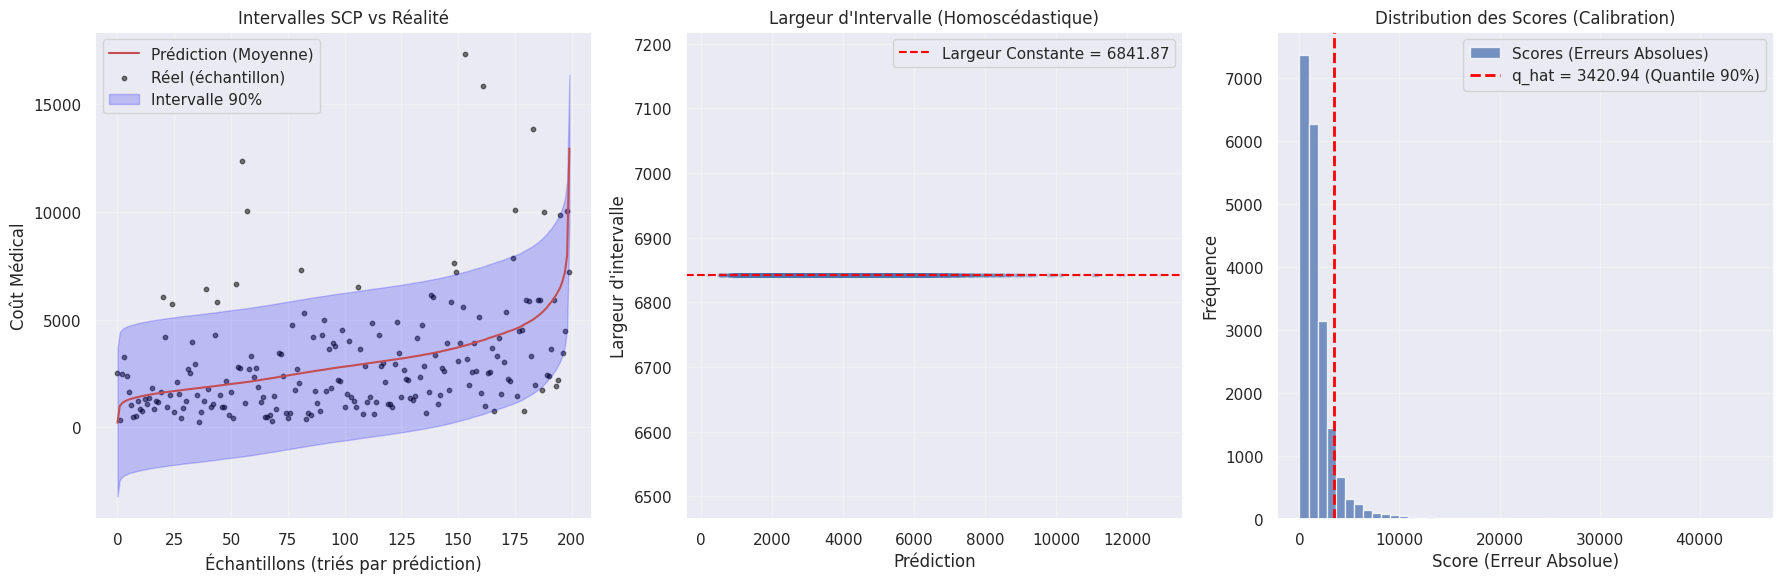


--- Évaluation des résultats ---
Couverture théorique (1-alpha): 90.00%
Couverture empirique (Test):  89.46%
Largeur moyenne de l'intervalle: 6841.87


In [97]:
import matplotlib.pyplot as plt

def plot_scp_results(results_df, y_test, scores_cal, q_hat, alpha=0.1, n_samples=200):
    """
    Visualise les résultats de la Split Conformal Prediction (Standard).
    
    Args:
        results_df (pd.DataFrame): Sortie de run_standard_conformal_prediction.
        y_test (pd.Series): Cibles de test.
        scores_cal (np.array): Scores de calibration.
        q_hat (float): Quantile calculé.
        alpha (float): Niveau de risque.
        n_samples (int): Nb d'échantillons pour le scatter plot.
    """
    
    y_test_values = y_test.values
    
    # Trier par prédiction pour une meilleure visualisation
    sorted_indices = np.argsort(results_df['prediction'].values)
    
    # Échantillonnage équilibré
    plot_indices = sorted_indices[np.linspace(0, len(sorted_indices) - 1, n_samples).astype(int)]
    
    x_plot = np.arange(n_samples)
    y_true_sample = y_test_values[plot_indices]
    preds_sample = results_df['prediction'].iloc[plot_indices].values
    low_sample = results_df['lower_bound'].iloc[plot_indices].values
    high_sample = results_df['upper_bound'].iloc[plot_indices].values

    plt.figure(figsize=(18, 6))

    # --- Plot 1: Intervalles vs Réalité ---
    plt.subplot(1, 3, 1)
    plt.plot(x_plot, preds_sample, 'r-', label='Prédiction (Moyenne)')
    plt.scatter(x_plot, y_true_sample, c='black', s=10, alpha=0.5, label='Réel (échantillon)')
    
    plt.fill_between(x_plot, low_sample, high_sample, alpha=0.2, color='blue', label=f'Intervalle {1-alpha:.0%}')
    
    plt.title('Intervalles SCP vs Réalité')
    plt.xlabel('Échantillons (triés par prédiction)')
    plt.ylabel('Coût Médical')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Plot 2: Largeur vs Prédiction ---
    plt.subplot(1, 3, 2)
    # Utiliser tous les points de test pour ce graphique
    width_full = results_df['upper_bound'] - results_df['lower_bound']
    
    plt.scatter(results_df['prediction'], width_full, alpha=0.1, s=5)
    plt.axhline(y=q_hat*2, color='red', linestyle='--', label=f'Largeur Constante = {q_hat*2:.2f}')
    
    plt.title('Largeur d\'Intervalle (Homoscédastique)')
    plt.xlabel('Prédiction')
    plt.ylabel('Largeur d\'intervalle')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Plot 3: Distribution des Scores de Calibration ---
    plt.subplot(1, 3, 3)
    plt.hist(scores_cal, bins=50, alpha=0.75, label='Scores (Erreurs Absolues)')
    plt.axvline(x=q_hat, color='red', linestyle='--', lw=2, label=f'q_hat = {q_hat:.2f} (Quantile {1-alpha:.0%})')
    
    plt.title('Distribution des Scores (Calibration)')
    plt.xlabel('Score (Erreur Absolue)')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_scp_results(results, y_test, scores, q_hat, alpha=alpha)

coverage_cqr, width_cqr = evaluate_conformal_results(results, y_test, alpha)


### __Analyse__

L'analyse de la SCP standard montre une correction q_hat très élevée de 3420.94, reflétant l'erreur importante du modèle de régression linéaire de base. Cette correction est appliquée uniformément, créant des intervalles de largeur constante (environ 6841.88 \$). Cette approche est inadaptée à nos données : elle ignore l'hétéroscédasticité et produit des bornes inférieures négatives (ex: -1282.97 \$) pour les faibles prédictions, ce qui est illogique pour des coûts médicaux.

### __<ins>Conformalized Quantile Regression<ins>__

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import QuantileRegressor

# Supprimer l'avertissement NumPy (interpolation)
warnings.filterwarnings("ignore", message=".*`interpolation=` argument to quantile.*")

def run_cqr(X_train, y_train, X_cal, y_cal, X_test, alpha=0.1):
    """
    Implémentation manuelle de la Conformalized Quantile Regression (CQR).
    
    Args:
        X_train, y_train: Données d'entraînement.
        X_cal, y_cal: Données de calibration.
        X_test: Données de test.
        alpha (float): Niveau de risque (ex: 0.1 pour 90% de couverture).
        
    Returns:
        pd.DataFrame: Résultats (bornes inf/sup, prédiction médiane estimée).
        np.array: Scores de calibration.
        float: Facteur de correction q_hat.
    """
    
    # Définir les quantiles cibles
    q_low = alpha / 2
    q_high = 1 - (alpha / 2)
    
    # Entraînement
    print(f"Entraînement des modèles QR (Quantiles: {q_low}, {q_high})...")
    
    model_low = QuantileRegressor(quantile=q_low, alpha=0.01, solver='highs')
    model_high = QuantileRegressor(quantile=q_high, alpha=0.01, solver='highs')
    
    model_low.fit(X_train, y_train)
    model_high.fit(X_train, y_train)

    # Calibration 
    print(f"Calibration sur {len(y_cal)} échantillons...")
    
    # Prédire les intervalles de base sur le set de calibration
    y_pred_low_cal = model_low.predict(X_cal)
    y_pred_high_cal = model_high.predict(X_cal)
    
    # Calculer les scores de non-conformité (scores CQR)
    scores = np.maximum(
        y_pred_low_cal - y_cal,  # Dépassement par le bas
        y_cal - y_pred_high_cal  # Dépassement par le haut
    )
    
    # Calcul du facteur de correction q
    n = len(y_cal)
    q_level = np.ceil((1 - alpha) * (n + 1)) / n
    q_level = min(q_level, 1.0) 

    q_hat = np.quantile(scores, q_level, method='higher')
    
    print(f"Niveau de risque (alpha): {alpha}")
    print(f"Facteur de correction CQR (q_hat): {q_hat:.2f}")

    # Prédiction
    print(f"Prédiction sur {len(X_test)} échantillons de test...")
    
    y_pred_low_test = model_low.predict(X_test)
    y_pred_high_test = model_high.predict(X_test)
    
    # Appliquer la correction q_hat
    lower_bound = y_pred_low_test - q_hat
    upper_bound = y_pred_high_test + q_hat
    
    pred_midpoint = (lower_bound + upper_bound) / 2
    
    results = pd.DataFrame({
        'prediction_midpoint': pred_midpoint,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
    
    return results, scores, q_hat

In [103]:
def plot_cqr_results(results_df, y_test, scores_cal, q_hat, alpha=0.1, n_samples=200):
    """
    Visualise les résultats de la Conformalized Quantile Regression (CQR).
    Met en évidence la largeur adaptative.
    """
    
    y_test_values = y_test.values
    
    # Trier par prédiction (point central)
    sorted_indices = np.argsort(results_df['prediction_midpoint'].values)
    plot_indices = sorted_indices[np.linspace(0, len(sorted_indices) - 1, n_samples).astype(int)]
    
    x_plot = np.arange(n_samples)
    y_true_sample = y_test_values[plot_indices]
    preds_sample = results_df['prediction_midpoint'].iloc[plot_indices].values
    low_sample = results_df['lower_bound'].iloc[plot_indices].values
    high_sample = results_df['upper_bound'].iloc[plot_indices].values

    plt.figure(figsize=(18, 6))

    # --- Plot 1: Intervalles vs Réalité (Adaptatif) ---
    plt.subplot(1, 3, 1)

    plt.plot(x_plot, preds_sample, 'r-', label='Point Central (estimé)', alpha=0.6)
    plt.scatter(x_plot, y_true_sample, c='black', s=10, alpha=0.5, label='Réel (échantillon)')
    
    # L'intervalle coloré
    plt.fill_between(x_plot, low_sample, high_sample, alpha=0.3, color='blue', label=f'Intervalle {1-alpha:.0%}')
    
    plt.title('Intervalles CQR vs Réalité (Adaptatif)')
    plt.xlabel('Échantillons (triés par prédiction)')
    plt.ylabel('Coût Médical')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Plot 2: Largeur vs Prédiction ---
    plt.subplot(1, 3, 2)
    width_full = results_df['upper_bound'] - results_df['lower_bound']
    
    # Échantillon pour la lisibilité
    sample_idx_plot2 = np.random.choice(len(width_full), 1000, replace=False)
    
    plt.scatter(
        results_df['prediction_midpoint'].iloc[sample_idx_plot2], 
        width_full.iloc[sample_idx_plot2], 
        alpha=0.1, s=10
    )
    
    plt.title('Largeur d\'Intervalle (Hétéroscédastique)')
    plt.xlabel('Prédiction (Point Central)')
    plt.ylabel('Largeur d\'intervalle')
    plt.grid(alpha=0.3)

    # --- Plot 3: Distribution des Scores de Calibration ---
    plt.subplot(1, 3, 3)
    plt.hist(scores_cal, bins=50, alpha=0.75, label='Scores CQR')
    plt.axvline(x=q_hat, color='red', linestyle='--', lw=2, label=f'q_hat = {q_hat:.2f} (Quantile {1-alpha:.0%})')
    
    plt.title('Distribution des Scores (Calibration)')
    plt.xlabel('Score (Dépassement de l\'intervalle)')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

--- Exécution de la CQR ---
Entraînement des modèles QR (Quantiles: 0.05, 0.95)...
Calibration sur 20000 échantillons...
Niveau de risque (alpha): 0.1
Facteur de correction CQR (q_hat): -14.69
Prédiction sur 20000 échantillons de test...

--- Premiers 5 intervalles de prédiction (CQR) ---
   prediction_midpoint  lower_bound   upper_bound
0          6072.735156   819.028898  11326.441414
1          3072.533029   472.327960   5672.738099
2          4132.451623   610.766704   7654.136541
3          3822.056475   584.617048   7059.495902
4          6081.876035   883.143971  11280.608099


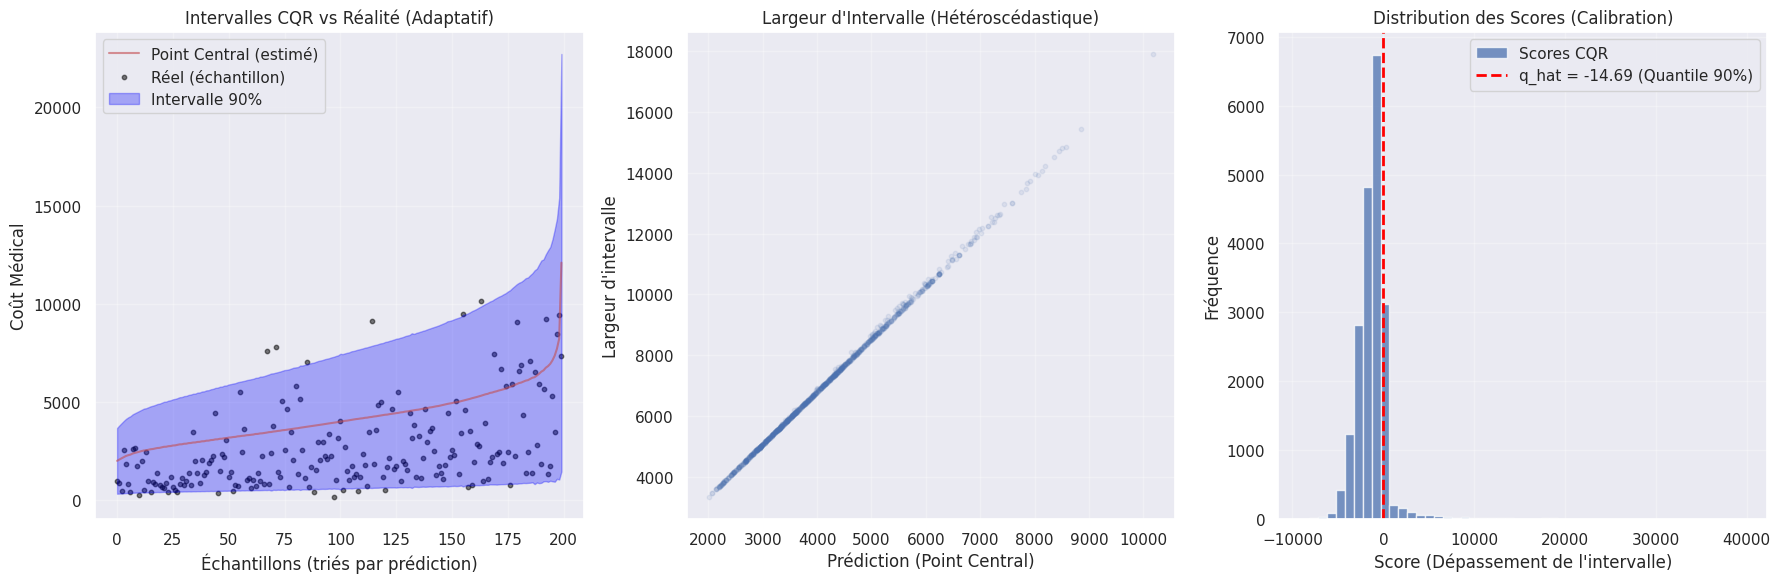


--- Évaluation des résultats ---
Couverture théorique (1-alpha): 90.00%
Couverture empirique (Test):  89.56%
Largeur moyenne de l'intervalle: 7091.57


In [ ]:
alpha = 0.1

print("--- Exécution de la CQR ---")
cqr_results, cal_scores_cqr, q_hat_cqr = run_cqr(
    X_train, 
    y_train, 
    X_cal, 
    y_cal, 
    X_test, 
    alpha=alpha
)

print("\n--- Premiers 5 intervalles de prédiction (CQR) ---")
print(cqr_results.head())

# Visualisation
plot_cqr_results(cqr_results, y_test, cal_scores_cqr, q_hat_cqr, alpha=alpha)

# Évaluation
coverage_cqr, width_cqr = evaluate_conformal_results(cqr_results, y_test, alpha)

### __Analyse__

1. <ins>SCP (Split Conformal Prediction Standard)<ins>

La méthode SCP, basée sur une LinearRegression, a produit un facteur de correction q_hat = 3420.94.

- Interprétation : Le modèle de régression linéaire se trompe de plus de 3421 $ dans au moins 10% des cas sur le set de calibration.

- Défaut Majeur : Cette correction est appliquée uniformément. Tous les intervalles de prédiction ont une largeur fixe de 6841.88 $ (2×3420.94).

- Conséquence : Cette approche est inadaptée à vos données. Elle produit des intervalles illogiques (bornes négatives) pour les faibles coûts et ne s'adapte pas à l'incertitude croissante (hétéroscédasticité) des coûts élevés.

2. <ins>CQR (Conformalized Quantile Regression)<ins>

La méthode CQR, basée sur vos QuantileRegressor (0.05 et 0.95), a produit un facteur de correction q_hat = -14.69.

- Interprétation : Ce résultat négatif est l'information la plus importante. Il signifie que vos modèles quantiles de base (entraînés sur X_train) étaient trop larges (sur-couverture). Lorsqu'ils ont été testés sur X_cal, ils couvraient plus que l'objectif de 90%.

- Action : L'algorithme CQR a donc rétréci l'intervalle de base pour atteindre précisément la couverture de 90%. L'intervalle final est [y_​low​+14.69,y_​high​−14.69].

- Avantage : La largeur de l'intervalle est adaptative (elle dépend des prédictions y_​low​ et y_​high​) et les bornes sont logiques (pas de coûts négatifs).

## <ins>__Prédiction Conforme pour la classification__<ins>

Nous changeons de tâche et de dataset pour aborder la classification (Cardiotocography). L'objectif n'est plus de prédire un intervalle numérique, mais un ensemble de prédiction pour la classe.

Au lieu de prédire une seule étiquette (ex: "Classe 3"), la prédiction conforme génère un ensemble de classes valides (ex: {Classe 3, Classe 4} ou {Classe 3}). L'objectif reste le même : garantir que la vraie classe se trouve dans cet ensemble avec un niveau de confiance défini (ex: 90%).

Nous implémenterons d'abord la méthode SCP (Split-Conformal) de base, puis la comparerons à CV+ pour évaluer l'efficacité.

### __Exploratory Data Analisys__

In [69]:
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X_features = cardiotocography.data.features 
y_targets = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 

{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

In [70]:
display(X_features.head(10), y_targets.head(10))

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.0,0.000,0.000,0.0,0.000,73,0.5,43,...,64,62,126,2,0,120,137,121,73,1
1,132,0.006,0.0,0.006,0.003,0.0,0.000,17,2.1,0,...,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.0,0.008,0.003,0.0,0.000,16,2.1,0,...,130,68,198,5,1,141,135,138,13,0
3,134,0.003,0.0,0.008,0.003,0.0,0.000,16,2.4,0,...,117,53,170,11,0,137,134,137,13,1
4,132,0.007,0.0,0.008,0.000,0.0,0.000,16,2.4,0,...,117,53,170,9,0,137,136,138,11,1
5,134,0.001,0.0,0.010,0.009,0.0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.0,0.013,0.008,0.0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
7,122,0.000,0.0,0.000,0.000,0.0,0.000,83,0.5,6,...,68,62,130,0,0,122,122,123,3,1
8,122,0.000,0.0,0.002,0.000,0.0,0.000,84,0.5,5,...,68,62,130,0,0,122,122,123,3,1
9,122,0.000,0.0,0.003,0.000,0.0,0.000,86,0.3,6,...,68,62,130,1,0,122,122,123,1,1


,CLASS,NSP
0,9,2
1,6,1
2,6,1
3,6,1
4,2,1
5,8,3
6,8,3
7,9,3
8,9,3
9,9,3


In [71]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

In [72]:
X_features.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


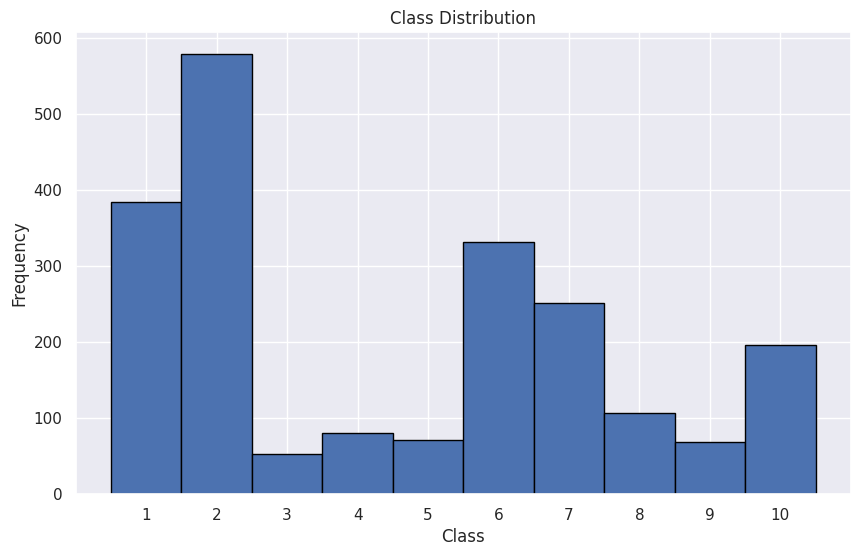

In [73]:
plt.figure(figsize=(10,6))
plt.hist(y_targets['CLASS'], bins=np.arange(1, 12)-0.5, edgecolor='black')
plt.xticks(range(1, 11))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

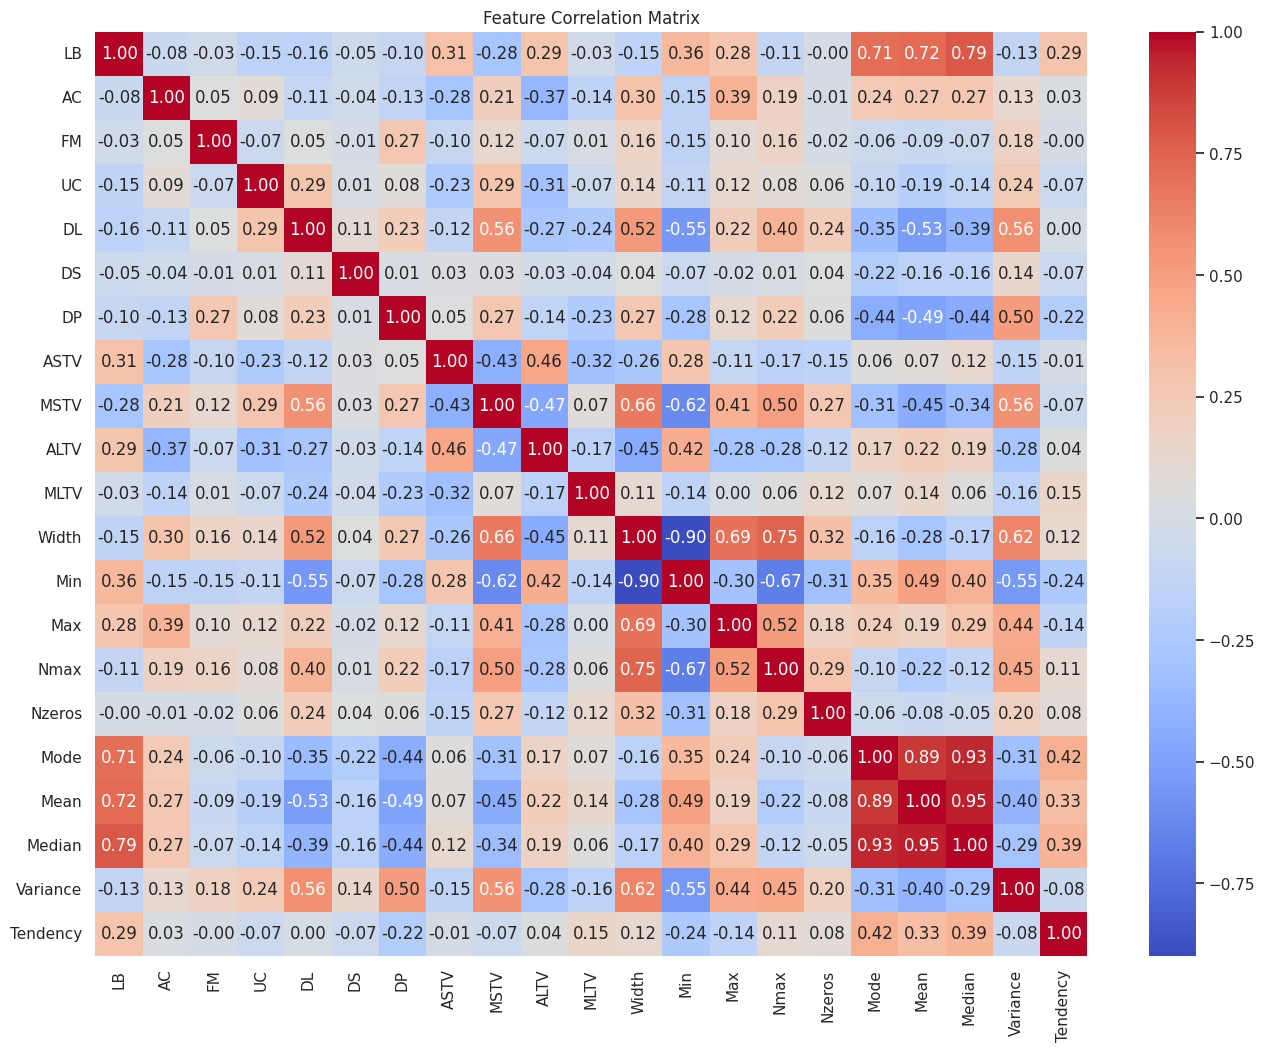

In [74]:
import seaborn as sns

cor_matrix = X_features.corr()

plt.figure(figsize=(16,12))
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### __Preprocessing__

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def prepare_data_conformal_clf(X_features, y_targets, target_col='CLASS', cal_size=0.2, test_size=0.2, random_state=42):
    """
    Prépare la donnée (X et y séparés) pour la prédiction conforme (Classification).
    - Sélectionne la colonne 'target_col' depuis 'y_targets'.
    - Remappe la cible si elle est 1-indexée (ex: 1-10 -> 0-9).
    - Applique StandardScaler à X_features.
    - Sépare en Train / Calibration / Test (stratifié).
    """
    
    # Définir X et y
    X = X_features
    try:
        y = y_targets[target_col].copy()
    except KeyError as e:
        print(f"Erreur : La colonne cible '{target_col}' n'est pas dans y_targets.")
        return None
            
    # Ajuster les labels de y
    if y.min() == 1:
        print(f"Labels de '{target_col}' remappés de {y.min()}-{y.max()} à {y.min()-1}-{y.max()-1}.")
        y = y - 1
            
    # Identifier les features (Toutes numériques)
    numeric_features = X.columns.tolist()
    
    # Définir le préprocesseur
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ],
        remainder='passthrough'
    )
    
    # Split en 3 ensembles (avec stratification)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    cal_size_adjusted = cal_size / (1.0 - test_size)
    
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_temp, y_temp, test_size=cal_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    # Appliquer le préprocesseur
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_cal_processed = preprocessor.transform(X_cal)
    X_test_processed = preprocessor.transform(X_test)
    
    # Conversion en DataFrames
    X_train_processed = pd.DataFrame(X_train_processed, columns=numeric_features, index=X_train.index)
    X_cal_processed = pd.DataFrame(X_cal_processed, columns=numeric_features, index=X_cal.index)
    X_test_processed = pd.DataFrame(X_test_processed, columns=numeric_features, index=X_test.index)
    
    print(f"\nTotal data: {len(X)}")
    print(f"Train set:  {len(X_train_processed)} ({len(X_train_processed)/len(X):.0%})")
    print(f"Calib set:  {len(X_cal_processed)} ({len(X_cal_processed)/len(X):.0%})")
    print(f"Test set:   {len(X_test_processed)} ({len(X_test_processed)/len(X):.0%})")
    
    return X_train_processed, X_cal_processed, X_test_processed, y_train, y_cal, y_test

X_train_clf, X_cal_clf, X_test_clf, y_train_clf, y_cal_clf, y_test_clf = prepare_data_conformal_clf(X_features, y_targets, target_col='CLASS', random_state=42)

print(f"\nLabels cibles (min/max): {y_train_clf.min()} / {y_train_clf.max()}")
print(f"Shape X_train: {X_train_clf.shape}")

Labels de 'CLASS' remappés de 1-10 à 0-9.

Total data: 2126
Train set:  1275 (60%)
Calib set:  425 (20%)
Test set:   426 (20%)

Labels cibles (min/max): 0 / 9
Shape X_train: (1275, 21)


### __Split Conformal Prediction__

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import warnings

# Entraînement du modèle
print("Entraînement du modèle de classification (Logistic Regression)...")
model_clf = LogisticRegression(
    solver='lbfgs',
    max_iter=1000, 
    random_state=42
)
model_clf.fit(X_train_clf, y_train_clf)
print("Entraînement terminé.")

# Calibration (Trouver q_hat)
def calibrate_scp_clf(model, X_cal, y_cal, alpha=0.1):
    """
    Calcule le quantile q_hat pour la classification SCP.
    """
    print(f"\nCalibration sur {len(y_cal)} échantillons...")
    
    # Prédire les probabilités sur l'ensemble de calibration
    probas_cal = model.predict_proba(X_cal)
    
    # Obtenir la probabilité de la VRAIE classe pour chaque échantillon
    true_class_probas = probas_cal[np.arange(len(y_cal)), y_cal.values]
    
    # Calculer les scores de non-conformité
    scores = 1 - true_class_probas
    
    # Calculer le quantile q_hat
    n = len(y_cal)
    q_level = np.ceil((1 - alpha) * (n + 1)) / n
    q_level = min(q_level, 1.0) 
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        q_hat = np.quantile(scores, q_level, interpolation='higher')

    print(f"Niveau de risque (alpha): {alpha}")
    print(f"Quantile calculé (q_hat): {q_hat:.4f}")
    
    return q_hat, scores

# Prédiction
def predict_scp_clf(model, X_test, q_hat):
    """
    Génère les ensembles de prédiction pour X_test.
    """
    print(f"\nPrédiction sur {len(X_test)} échantillons de test...")
    
    # Seuil de probabilité
    threshold = 1 - q_hat
    print(f"Seuil de probabilité (1 - q_hat): {threshold:.4f}")

    # Prédire les probabilités sur l'ensemble de test
    probas_test = model.predict_proba(X_test)
    
    prediction_sets = []
    for sample_probas in probas_test:
        # L'ensemble inclut toutes les classes k tant que p(k) >= seuil
        set_for_sample = np.where(sample_probas >= threshold)[0]
        
        # Gestion des ensembles vides (si q_hat est trop bas)
        if len(set_for_sample) == 0:
            # Si vide, inclure la classe la plus probable (fallback)
            set_for_sample = [np.argmax(sample_probas)]
            
        prediction_sets.append(list(set_for_sample))
        
    return prediction_sets

# Évaluation
def evaluate_scp_clf(prediction_sets, y_test, alpha):
    """
    Évalue la couverture et la taille des ensembles de prédiction.
    """
    y_test_values = y_test.values
    
    # Couverture
    in_set_count = 0
    for i in range(len(y_test_values)):
        if y_test_values[i] in prediction_sets[i]:
            in_set_count += 1
            
    coverage = in_set_count / len(y_test_values)
    
    # Taille des ensembles
    set_sizes = [len(s) for s in prediction_sets]
    avg_size = np.mean(set_sizes)
    
    print(f"\n--- Évaluation SCP Classification ---")
    print(f"Couverture théorique: {1-alpha:.2%}")
    print(f"Couverture empirique: {coverage:.2%}")
    print(f"Taille moyenne des ensembles: {avg_size:.2f} (sur 10 classes)")
    
    return coverage, avg_size, set_sizes

# Affichage des probabilités
def display_prediction_probabilities(model, X_test, y_test, pred_sets, q_hat, n_samples=5):
    """
    Affiche les probabilités détaillées pour les n premiers échantillons de test.
    
    Args:
        model: Le modèle de classification entraîné.
        X_test (pd.DataFrame): Données de test.
        y_test (pd.Series): Cibles de test.
        pred_sets (list): Liste des ensembles de prédiction.
        q_hat (float): Le quantile de calibration.
        n_samples (int): Nombre d'échantillons à afficher.
    """
    # Recalculer le seuil de probabilité
    threshold = 1 - q_hat
    
    # Obtenir les probabilités pour les n premiers échantillons
    probas_test = model.predict_proba(X_test.iloc[:n_samples])
    
    print(f"\n--- Affichage Détaillé des {n_samples} Premières Prédictions ---")
    print(f"Seuil de probabilité (1 - q_hat): {threshold:.4f} (Toute classe >= {threshold*100:.2f}% est incluse)")
    
    for i in range(n_samples):
        true_class = y_test.iloc[i]
        pred_set = pred_sets[i]
        sample_probas = probas_test[i]
        
        print(f"\n--- Échantillon {i} ---")
        print(f"VRAIE CLASSE: {true_class}")
        print(f"ENSEMBLE PRÉDIT: {pred_set}")
        
        # Vérifier si la prédiction était correcte
        is_correct = true_class in pred_set
        print(f"Résultat: {'CORRECT' if is_correct else 'ERREUR'}")

        print("Probabilités (Softmax):")
        
        # Trier les probabilités pour la lisibilité
        sorted_indices = np.argsort(sample_probas)[::-1]

        for k in sorted_indices:
            prob_pct = sample_probas[k] * 100
        
            if prob_pct < 0.1:
                continue
                
            # Mettre en surbrillance si > seuil
            highlight = " (INCLUS)" if sample_probas[k] >= threshold else ""
            
            # Mettre en surbrillance si c'est la vraie classe
            true_class_marker = " (VRAIE CLASSE)" if k == true_class else ""
            
            print(f"  Classe {k}: {prob_pct:6.2f}%{highlight}{true_class_marker}")

Entraînement du modèle de classification (Logistic Regression)...
Entraînement terminé.


In [ ]:
alpha = 0.1

# Calibration
q_hat_clf, cal_scores_clf = calibrate_scp_clf(
    model_clf, 
    X_cal_clf, 
    y_cal_clf, 
    alpha=alpha
)

# Prédiction
pred_sets_clf = predict_scp_clf(model_clf, X_test_clf, q_hat_clf)

# Évaluation
coverage_clf, avg_size_clf, set_sizes_clf = evaluate_scp_clf(
    pred_sets_clf, 
    y_test_clf, 
    alpha=alpha
)

print("\nExemple de 5 premiers ensembles de prédiction :")
for i in range(5):
    print(f"  Vraie classe: {y_test_clf.iloc[i]}, Ensemble Prédit: {pred_sets_clf[i]}")

# Affichage des probabilités
display_prediction_probabilities(
    model_clf, 
    X_test_clf, 
    y_test_clf, 
    pred_sets_clf, 
    q_hat_clf, 
    n_samples=5
)


Calibration sur 425 échantillons...
Niveau de risque (alpha): 0.1
Quantile calculé (q_hat): 0.7457

Prédiction sur 426 échantillons de test...
Seuil de probabilité (1 - q_hat): 0.2543

--- Évaluation SCP Classification ---
Couverture théorique: 90.00%
Couverture empirique: 91.31%
Taille moyenne des ensembles: 1.28 (sur 10 classes)

Exemple de 5 premiers ensembles de prédiction :
  Vraie classe: 0, Ensemble Prédit: [0, 9]
  Vraie classe: 6, Ensemble Prédit: [6]
  Vraie classe: 1, Ensemble Prédit: [1]
  Vraie classe: 6, Ensemble Prédit: [7]
  Vraie classe: 0, Ensemble Prédit: [0]

--- Affichage Détaillé des 5 Premières Prédictions ---
Seuil de probabilité (1 - q_hat): 0.2543 (Toute classe >= 25.43% est incluse)

--- Échantillon 0 ---
VRAIE CLASSE: 0
ENSEMBLE PRÉDIT: [0, 9]
Résultat: CORRECT
Probabilités (Softmax):
  Classe 0:  65.73% (INCLUS) (VRAIE CLASSE)
  Classe 9:  30.43% (INCLUS)
  Classe 4:   1.72%
  Classe 1:   1.00%
  Classe 8:   0.84%
  Classe 2:   0.20%

--- Échantillon 1 ---

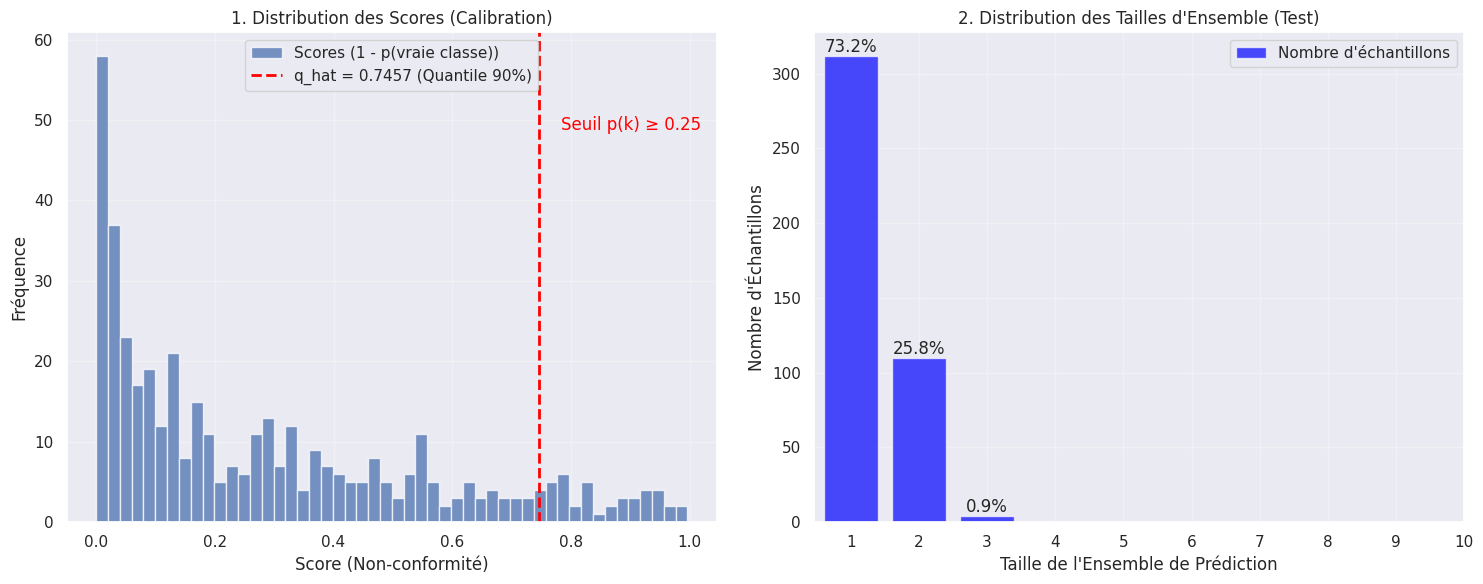

In [88]:
def plot_scp_clf_results(scores_cal, q_hat, set_sizes, alpha=0.1):
    """
    Visualise les résultats de la SCP pour la classification.
    
    Args:
        scores_cal (np.array): Scores (1 - p(vraie classe)) du set de calibration.
        q_hat (float): Quantile calculé (seuil de score).
        set_sizes (list or np.array): Tailles des ensembles de prédiction du set de test.
        alpha (float): Niveau de risque.
    """
    
    plt.figure(figsize=(15, 6))

    # --- Plot 1: Distribution des Scores de Calibration ---
    plt.subplot(1, 2, 1)
    plt.hist(scores_cal, bins=50, alpha=0.75, label='Scores (1 - p(vraie classe))')
    plt.axvline(x=q_hat, color='red', linestyle='--', lw=2, 
                label=f'q_hat = {q_hat:.4f} (Quantile {1-alpha:.0%})')
    
    # Indiquer le seuil de probabilité résultant
    threshold = 1 - q_hat
    plt.text(q_hat * 1.05, plt.gca().get_ylim()[1] * 0.8, 
             f'Seuil p(k) ≥ {threshold:.2f}', color='red')
             
    plt.title('1. Distribution des Scores (Calibration)')
    plt.xlabel('Score (Non-conformité)')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Plot 2: Distribution des Tailles d'Ensemble ---
    plt.subplot(1, 2, 2)
    
    # Calculer les comptages pour chaque taille d'ensemble
    sizes, counts = np.unique(set_sizes, return_counts=True)
    
    # Graphique en barres pour les tailles discrètes
    bars = plt.bar(sizes, counts, color='blue', alpha=0.7, 
                   label='Nombre d\'échantillons')
    
    plt.title('2. Distribution des Tailles d\'Ensemble (Test)')
    plt.xlabel('Taille de l\'Ensemble de Prédiction')
    plt.ylabel('Nombre d\'Échantillons')
    
    # S'assurer que tous les ticks de 1 à 10 (ou max) sont affichés
    max_size = 10 # Nombre de classes
    plt.xticks(np.arange(1, max_size + 1))
    
    # Ajouter les pourcentages au-dessus des barres
    total_counts = np.sum(counts)
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width() / 2.0, height,
                     f'{(height / total_counts):.1%}',
                     ha='center', va='bottom')

    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_scp_clf_results(cal_scores_clf, q_hat_clf, set_sizes_clf, alpha=alpha)

### __Analyse__

L'évaluation de la méthode SCP (Split-Conformal) de base démontre des performances robustes et fiables. La couverture empirique observée sur l'ensemble de test est de 91.31%, ce qui respecte et dépasse légèrement la garantie théorique de 90.00%. La validité de l'approche conforme est ainsi confirmée pour ce modèle. L'efficacité prédictive est mise en évidence par une taille moyenne d'ensemble de 1.28. Sur 10 classes possibles, ce résultat est excellent et indique que le modèle est très décisif, ne retournant le plus souvent qu'une seule classe candidate. Le processus de calibration a établi un seuil de probabilité à 25.43% (basé sur q_hat = 0.7457). L'analyse détaillée des prédictions confirme le bon fonctionnement de ce seuil : il inclut plusieurs classes lorsque l'ambiguïté est élevée (ex: {0, 9}) tout en illustrant les erreurs de couverture attendues (ex: prédiction {7} pour la vraie classe 6 lorsque celle-ci n'atteint pas le seuil).

### __CV+__

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings


# Combiner les données d'entraînement et de calibration
X_full_train = pd.concat([X_train_clf, X_cal_clf]).reset_index(drop=True)
y_full_train = pd.concat([y_train_clf, y_cal_clf]).reset_index(drop=True)

print(f"Taille du set d'entraînement SCP: {len(X_train_clf)}")
print(f"Taille du set complet (CV+): {len(X_full_train)}")

# Entraînement et Calibration (CV+)
def run_cv_plus(X_full, y_full, base_model, n_splits=10, alpha=0.1):
    """
    Implémentation manuelle de CV+.
    """
    print(f"\nExécution de CV+ avec {n_splits} folds...")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    all_scores = np.array([])
    trained_models = []
    
    # K-Fold loop
    for fold_idx, (train_indices, cal_indices) in enumerate(skf.split(X_full, y_full)):
        
        # Définir les données du fold
        X_train_fold = X_full.iloc[train_indices]
        y_train_fold = y_full.iloc[train_indices]
        X_cal_fold = X_full.iloc[cal_indices]
        y_cal_fold = y_full.iloc[cal_indices]
        
        model_fold = clone(base_model)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Calibration sur le fold tenu à l'écart
        probas_cal_fold = model_fold.predict_proba(X_cal_fold)
        
        # Obtenir la probabilité de la VRAIE classe
        true_class_probas = probas_cal_fold[np.arange(len(y_cal_fold)), y_cal_fold.values]
        
        # Calculer les scores
        scores_fold = 1 - true_class_probas
        all_scores = np.concatenate([all_scores, scores_fold])
        
        # Stocker le modèle entraîné
        trained_models.append(model_fold)
        
    print(f"Calibration CV+ terminée. {len(all_scores)} scores calculés.")

    # Calcul du q_hat global
    n = len(all_scores)
    q_level = np.ceil((1 - alpha) * (n + 1)) / n
    q_level = min(q_level, 1.0) 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        q_hat = np.quantile(all_scores, q_level, interpolation='higher')

    print(f"Quantile CV+ (q_hat): {q_hat:.4f}")
    
    return trained_models, all_scores, q_hat

# Prédiction (CV+)
def predict_cv_plus(models_list, X_test, q_hat):
    """
    Génère les ensembles de prédiction en agrégeant les K modèles de CV+.
    """
    print(f"\nPrédiction CV+ sur {len(X_test)} échantillons...")
    
    # Seuil de probabilité
    threshold = 1 - q_hat
    print(f"Seuil de probabilité (1 - q_hat): {threshold:.4f}")

    # Collecter les probabilités de tous les modèles
    all_probas = []
    for model in models_list:
        all_probas.append(model.predict_proba(X_test))
        
    # Agréger les probabilités (moyenne)
    avg_probas = np.mean(all_probas, axis=0)
    
    # Appliquer le seuil
    prediction_sets = []
    for sample_probas in avg_probas:
        set_for_sample = np.where(sample_probas >= threshold)[0]
        
        if len(set_for_sample) == 0:
            set_for_sample = [np.argmax(sample_probas)]
            
        prediction_sets.append(list(set_for_sample))
        
    return prediction_sets

# Affichage des probabilités
def display_prediction_probabilities_cv(models_list, X_test, y_test, pred_sets, q_hat, n_samples=5):
    """
    Affiche les probabilités détaillées pour CV+.
    
    Args:
        models_list (list): La liste des K modèles entraînés par CV+.
        X_test (pd.DataFrame): Données de test.
        y_test (pd.Series): Cibles de test.
        pred_sets (list): Liste des ensembles de prédiction (issus de CV+).
        q_hat (float): Le quantile de calibration (issu de CV+).
        n_samples (int): Nombre d'échantillons à afficher.
    """
    # Recalculer le seuil de probabilité
    threshold = 1 - q_hat
    
    # Calcul des probabilités moyennes
    X_test_samples = X_test.iloc[:n_samples]
    all_probas = []
    for model in models_list:
        all_probas.append(model.predict_proba(X_test_samples))
    
    avg_probas = np.mean(all_probas, axis=0)
    
    print(f"\n--- Affichage Détaillé (CV+) des {n_samples} Premières Prédictions ---")
    print(f"Seuil de probabilité (1 - q_hat): {threshold:.4f} (Toute classe >= {threshold*100:.2f}% est incluse)")
    
    for i in range(n_samples):
        true_class = y_test.iloc[i]
        pred_set = pred_sets[i]
        sample_probas = avg_probas[i] 
        
        print(f"\n--- Échantillon {i} ---")
        print(f"VRAIE CLASSE: {true_class}")
        print(f"ENSEMBLE PRÉDIT: {pred_set}")
        
        is_correct = true_class in pred_set
        print(f"Résultat: {'CORRECT' if is_correct else 'ERREUR'}")

        print("Probabilités (Moyenne des 10 modèles):")
        
        sorted_indices = np.argsort(sample_probas)[::-1]
        
        for k in sorted_indices:
            prob_pct = sample_probas[k] * 100
            
            if prob_pct < 0.1:
                continue
                
            highlight = " (INCLUS)" if sample_probas[k] >= threshold else ""
            true_class_marker = " (VRAIE CLASSE)" if k == true_class else ""
            
            print(f"  Classe {k}: {prob_pct:6.2f}%{highlight}{true_class_marker}")

Taille du set d'entraînement SCP: 1275
Taille du set complet (CV+): 1700



Exécution de CV+ avec 10 folds...
Calibration CV+ terminée. 1700 scores calculés.
Quantile CV+ (q_hat): 0.7323

Prédiction CV+ sur 426 échantillons...
Seuil de probabilité (1 - q_hat): 0.2677

--- Évaluation SCP Classification ---
Couverture théorique: 90.00%
Couverture empirique: 90.38%
Taille moyenne des ensembles: 1.24 (sur 10 classes)

--- Affichage Détaillé (CV+) des 5 Premières Prédictions ---
Seuil de probabilité (1 - q_hat): 0.2677 (Toute classe >= 26.77% est incluse)

--- Échantillon 0 ---
VRAIE CLASSE: 0
ENSEMBLE PRÉDIT: [0, 9]
Résultat: CORRECT
Probabilités (Moyenne des 10 modèles):
  Classe 0:  68.73% (INCLUS) (VRAIE CLASSE)
  Classe 9:  27.13% (INCLUS)
  Classe 4:   2.05%
  Classe 1:   1.17%
  Classe 8:   0.67%
  Classe 2:   0.17%

--- Échantillon 1 ---
VRAIE CLASSE: 6
ENSEMBLE PRÉDIT: [6]
Résultat: CORRECT
Probabilités (Moyenne des 10 modèles):
  Classe 6:  99.04% (INCLUS) (VRAIE CLASSE)
  Classe 5:   0.91%

--- Échantillon 2 ---
VRAIE CLASSE: 1
ENSEMBLE PRÉDIT: [1]
Résu

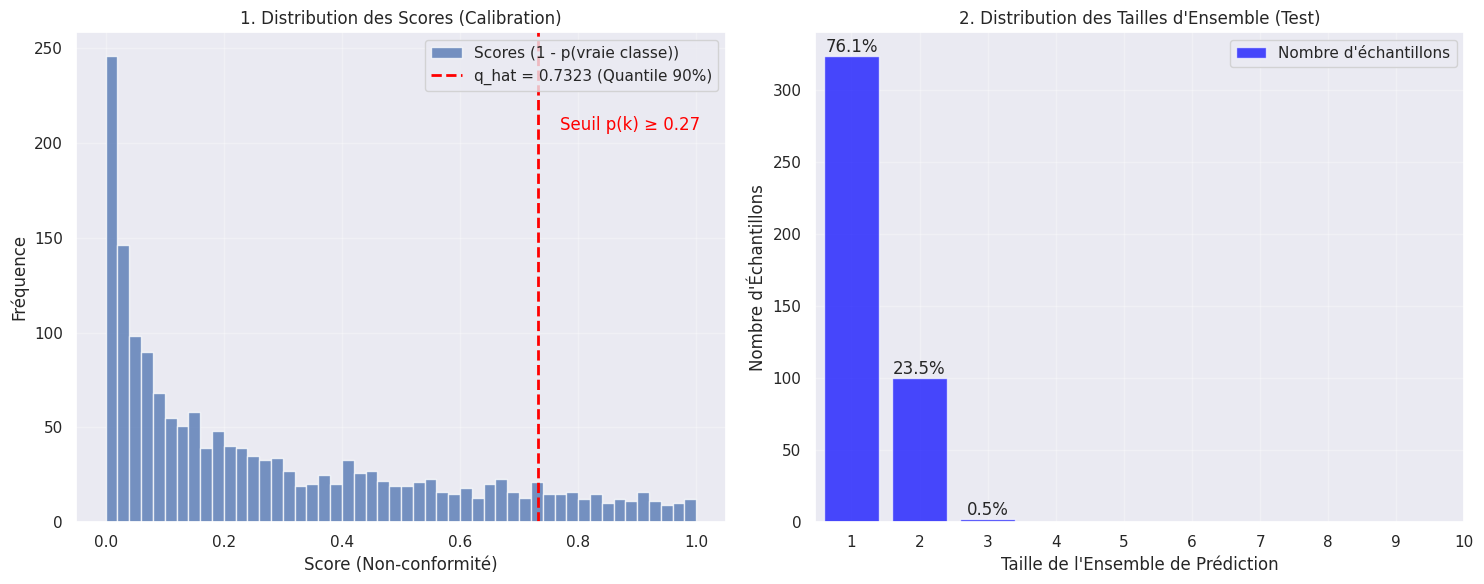


--- Comparaison ---
SCP (base): Taille moyenne=1.28, Couverture=91.31%
CV+ (K=10): Taille moyenne=1.24, Couverture=90.38%


In [ ]:
alpha = 0.1

# Définir le modèle de base 
base_model_clf = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000, 
    random_state=42
)

# Exécuter l'entraînement et la calibration CV+
models_cv, scores_cv, q_hat_cv = run_cv_plus(
    X_full_train, 
    y_full_train, 
    base_model_clf, 
    n_splits=10, 
    alpha=alpha
)

# Prédiction sur le set de Test
pred_sets_cv = predict_cv_plus(models_cv, X_test_clf, q_hat_cv)

# Évaluation
coverage_cv, avg_size_cv, set_sizes_cv = evaluate_scp_clf(
    pred_sets_cv, 
    y_test_clf, 
    alpha=alpha
)

# Affichage des probabilités
display_prediction_probabilities_cv(
    models_cv,       
    X_test_clf, 
    y_test_clf, 
    pred_sets_cv,    
    q_hat_cv,        
    n_samples=5
)

# Visualisation
plot_scp_clf_results(scores_cv, q_hat_cv, set_sizes_cv, alpha=alpha)

# Comparaison
print("\n--- Comparaison ---")
print(f"SCP (base): Taille moyenne={avg_size_clf:.2f}, Couverture={coverage_clf:.2%}")
print(f"CV+ (K=10): Taille moyenne={avg_size_cv:.2f}, Couverture={coverage_cv:.2%}")

### __Analyse__

L'implémentation de CV+ démontre une amélioration notable de l'efficacité par rapport à la méthode SCP de base.

En entraînant des modèles sur des ensembles de données plus larges (utilisant 10 folds), la méthode obtient un q_hat plus faible de 0.7323, ce qui résulte en un seuil de probabilité plus strict (26.77%). La couverture empirique de 90.38% est calibrée de manière plus précise à l'objectif théorique de 90.00% que ne l'était le SCP (91.31%).

L'avantage principal est la réduction de la taille moyenne des ensembles à 1.24 (contre 1.28 pour le SCP). Cela confirme que CV+ est non seulement fiable, mais aussi plus efficace et décisif, car ses modèles sous-jacents (entraînés sur plus de données) sont plus performants.